In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-ner/Corona2.json


In [2]:
!pip install -U spacy[cuda,transformers,lookups]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 30.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.9/815.9 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 12.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.3 MB/s eta 0:00:00
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.17
    Uninstalling thinc-8.0.17:
      Successfully uninstalled thinc-8.0.17
  Attempting uninstall: spacy
    Found existing installation: spacy 3.3.2
    Uninstalling spacy-3.3.2:
      Successfully uninstalled spacy-3.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.3.0 requires spacy<3.4.0,>=3.3.0.dev0, but you have spacy 3.4.4 which is incompatible.
en

In [3]:
import pandas as pd 
import numpy as np
import random 
from tqdm import tqdm
import spacy 
from spacy import displacy
from spacy.training import Example
from spacy.scorer import Scorer
from spacy.util import minibatch
from spacy.tokens import Doc

import json
import warnings
warnings.filterwarnings("ignore")


2023-01-17 14:50:42.104229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:50:42.105102: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:50:42.106081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:50:42.106799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:50:42.107484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [4]:
spacy.prefer_gpu()

True

In [5]:
!pip install 'spacy[transformers]'

In [6]:
with open("/kaggle/input/medical-ner/Corona2.json", "r") as f:
    data = json.load(f)
    
type(data)

dict

In [7]:
df = pd.read_json("/kaggle/input/medical-ner/Corona2.json")
df

,examples
0,"{'id': '18c2f619-f102-452f-ab81-d26f7e283ffe',..."
1,"{'id': '487c93e3-0d45-4088-a378-cf3a01c8953d',..."
2,"{'id': 'd5056874-895a-4a7f-9e0f-828d414d65d9',..."
3,"{'id': '20c792c7-0c4b-42d0-8127-0e04113db384',..."
4,"{'id': 'f5359e0d-4d4a-4707-95a3-4c627fc4a83b',..."
5,"{'id': 'b3481879-a9cd-48db-8526-8ee11c9a72bc',..."
6,"{'id': '8ecb663a-c4d5-4351-9b9c-40f724ff936d',..."
7,"{'id': 'f2f13903-be8b-4981-8702-4ee992f90534',..."
8,"{'id': '5d1621d3-b877-4747-aceb-ecf807a6c9ec',..."
9,"{'id': '9a0b1ede-2282-4dae-b086-638e45881bf5',..."


In [8]:
examp = df["examples"][0]
examp

{'id': '18c2f619-f102-452f-ab81-d26f7e283ffe',
 'content': "While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]",
 'metadata': {},
 'annotations': [{'id': '0825a1

In [12]:
train_data = []
medicalCondition = set()
medicine = set()
pathogen = set()
for index,value in df["examples"].iteritems():
    entities = []
    for annot in value["annotations"]:
        if len(annot["value"]) == len(annot["value"].strip()):
            if len(annot["human_annotations"]) == 0:
                continue
            entities.append((annot["start"],annot["end"], annot["tag_name"],annot["value"]))
            
    if len(entities) > 0:
        train_data.append(([value["content"], {"entities" : entities}]))
        
    for x in train_data:
        for y in x[1]["entities"]:
            if y[2] == "Medicine":
                medicine.add(y[3])
            elif y[2] == "MedicalCondition":
                medicalCondition.add(y[3])
            else:
                pathogen.add(y[3])
                

In [14]:
train_data[0]

["While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]",
 {'entities': [(360, 371, 'Medicine', 'Diosmectite'),
   (383, 408, 'Medicine', 'aluminomagnesium silicate

In [15]:
medicalCondition

{'Bites',
 'Cellulitis',
 'Diarrhea',
 "Hansen's disease",
 'Influenza',
 "Parkinson's disease",
 'SARS',
 'abdominal pain',
 'animal bites',
 'anxiety disorder',
 'asthma',
 'avian influenza',
 'bipolar disorder',
 'blisters',
 'candidiasis',
 'chest pain',
 'chickenpox',
 'constipation',
 'cough up blood',
 'coughing',
 'cracks in the skin',
 'cystitis',
 'decrease in responsiveness',
 'dehydration',
 'diarrhea',
 'diarrhoea',
 'died',
 'dies',
 'diphtheria',
 'epileptic seizures',
 'extensive scarring',
 'extrapulmonary infection',
 'extrapulmonary tuberculosis',
 'fast heart rate',
 'feeling tired',
 'flatulence',
 'folic acid',
 'foodborne illnesses',
 'headache',
 'heart failure',
 'hyperactivity disorder',
 'inflammation',
 'influenza',
 'joint pain',
 'leprosy',
 'loss of skin color',
 'massive bleeding',
 'migraine prophylaxis',
 'miliary tuberculosis',
 'multiple sclerosis',
 'nausea',
 'nephritis',
 'neuromyotonia',
 'neuropathic pain syndromes',
 'pain during urination',
 '

In [16]:
medicine

{'ART',
 'Antiretroviral therapy',
 'Biological DMARDs',
 'Buprenorphine',
 'Bupropion',
 'Carbamazepine',
 'DMARDs',
 'Diosmectite',
 'Gabapentin',
 'Hydroxychloroquine',
 'Leflunomide',
 'M2 inhibitors',
 'MAOIs',
 'Methotrexate',
 'Moclobemide',
 'Pepto-Bismol',
 'Phenelzine',
 'RA treatment',
 'Racecadotril',
 'Rituximab',
 'Sertraline',
 'Sodium aurothiomalate',
 'Sulfasalazine',
 'TB therapy',
 'TNF-alpha inhibitors',
 'Wellbutrin',
 'Zyban',
 'adamantane',
 'aluminomagnesium silicate',
 'amantadine',
 'amoxicillin',
 'anthrax vaccine',
 'bedaquiline',
 'bismuth compounds',
 'carmantadine',
 'certolizumab',
 'chemotherapy',
 'ciprofloxacin',
 'clomipramine',
 'cyclosporin',
 'dopamantine',
 'doxycycline',
 'escitalopram',
 'etanercept',
 'fluoxetine',
 'fluvoxamine',
 'hydroxychloroquine',
 'imipramine',
 'infliximab',
 'intravenous catheter insertion',
 'intravenous drug injection',
 'isoniazid',
 'kaopectate',
 'laninamivir',
 'leflunomide',
 'loperamide',
 'methotrexate',
 'mo

In [17]:
pathogen

{'Bacterial gastroenteritis',
 'Bacterial meningitis',
 'Bacterial pneumonia',
 'Bacterial vaginosis',
 'Brucella',
 'Bunyaviridae',
 'Campylobacter',
 'Ebola virus',
 'Epstein–Barr virus',
 'Erysipelas',
 'Escherichia',
 'Escherichia coli',
 'Francisella',
 'HIV',
 'Hantaviruses',
 'Lactobacilli',
 'Legionella',
 'Listeria',
 'Magboi virus',
 'Mouyassué virus',
 'Mycobacterium',
 'Mycobacterium tuberculosis',
 'Neisseria',
 'Nocardia',
 'Pseudomonas',
 'Rabies virus',
 'SARS coronavirus',
 'SARS-CoV',
 'Salmonella',
 'Shigella',
 'Staphylococcus aureus',
 'Streptococcus',
 'Streptococcus pyogenes',
 'Trichomonas vaginalis',
 'Yersinia pestis',
 'bacteria',
 'bacterial inflammation',
 'bacterial pneumonia',
 'bacterium',
 'bornavirus',
 'coronavirus',
 'fungus',
 'herpes simplex virus',
 'herpesvirus 6',
 'infectious microorganism',
 'influenza virus',
 'pathogenic bacteria',
 'protozoan',
 'rabies virus',
 'varicella zoster virus',
 'virus'}

In [18]:
nlp = spacy.blank('en')        

In [19]:
nlp.pipeline

[]

In [20]:
from spacy.tokenizer import util
config = {
    "model": {
        "@architectures": "spacy-transformers.TransformerModel.v3",
        "name": "bert-base-uncased",
        "tokenizer_config": {"use_fast": True},
        "transformer_config": {"output_attentions": True},
        "mixed_precision": True,
        "grad_scaler_config": {"init_scale": 32768}
    }
}


In [21]:
type(nlp)

spacy.lang.en.English

In [22]:
nlp.pipeline

[]

In [23]:
import torch
from torch.optim import Adam

In [24]:
from spacy.pipeline import EntityRuler
class RulerModel():
    def __init__(self,medicalCondition,medicine,pathogen):
        self.ruler_model = spacy.blank("en")
        self.entity_ruler = self.ruler_model.add_pipe("entity_ruler")
        total_patterns = []
        patterns = self.generate_patterns(medicalCondition,"MedicalCondition")
        total_patterns.extend(patterns)
        
        patterns = self.generate_patterns(medicine,"Medicine")
        total_patterns.extend(patterns)
        
        patterns = self.generate_patterns(pathogen,"Pathogen")
        total_patterns.extend(patterns)
        
        self.add_patterns_into_ruler(total_patterns)
        
        self.save_ruler_model()
        
    def generate_patterns(self,entity_type_set,entity_type):
        patterns = []
        for item in entity_type_set:
            pattern = {"label": entity_type, "pattern": item}
            patterns.append(pattern)
            
        return patterns
    
    def add_patterns_into_ruler(self,total_patterns):
        self.entity_ruler.add_patterns(total_patterns)
        
    def save_ruler_model(self):
        self.entity_ruler.to_disk("/kaggle/working/")



In [25]:
ruler_model = RulerModel(medicalCondition,medicine,pathogen)

In [26]:
ruler_model.ruler_model.pipeline

[('entity_ruler', <spacy.pipeline.entityruler.EntityRuler at 0x7f9af0afffa0>)]

In [27]:
class GenerateDataset(object):
    
    def __init__(self,ruler_model):
        self.ruler_model = ruler_model
        
    def find_entity_types(self,text):
        ents = []
        doc = self.ruler_model.ruler_model(str(text))
        for ent in doc.ents:
            ents.append((ent.start_char,ent.end_char,ent.label_))
            
        return ents
    
    def assign_labels_to_documents(self,train_data):
        dataset = []
        text_list = []
        for val in train_data:
            text_list += [val[0]]
            
        for text in text_list:
            ents = self.find_entity_types(text)
            if len(ents) > 0:
                dataset.append((text, {"entities": ents}))
            else:
                continue
            
        return dataset

In [28]:
dataset = GenerateDataset(ruler_model)

In [29]:
labelled_dataset = dataset.assign_labels_to_documents(train_data)
labelled_dataset[:2]

[("While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]",
  {'entities': [(6, 23, 'Medicine'),
    (25, 37, 'Medicine'),
    (104, 112, 'MedicalCondition'),
    (1

In [30]:
len(labelled_dataset)

30

In [31]:
length_list = len(labelled_dataset)
portion = int(length_list * 0.8)
training_dataset = labelled_dataset[:portion]
validation_dataset = labelled_dataset[portion:]
len(training_dataset)


24

In [32]:
len(validation_dataset)

6

In [33]:
training_dataset[0]

("While bismuth compounds (Pepto-Bismol) decreased the number of bowel movements in those with travelers' diarrhea, they do not decrease the length of illness.[91] Anti-motility agents like loperamide are also effective at reducing the number of stools but not the duration of disease.[8] These agents should be used only if bloody diarrhea is not present.[92]\n\nDiosmectite, a natural aluminomagnesium silicate clay, is effective in alleviating symptoms of acute diarrhea in children,[93] and also has some effects in chronic functional diarrhea, radiation-induced diarrhea, and chemotherapy-induced diarrhea.[45] Another absorbent agent used for the treatment of mild diarrhea is kaopectate.\n\nRacecadotril an antisecretory medication may be used to treat diarrhea in children and adults.[86] It has better tolerability than loperamide, as it causes less constipation and flatulence.[94]",
 {'entities': [(6, 23, 'Medicine'),
   (25, 37, 'Medicine'),
   (104, 112, 'MedicalCondition'),
   (188, 1

In [34]:
validation_dataset[0]

('Gabapentin, approved for treatment of seizures and postherpetic neuralgia in adults, has side-effects which are useful in treating bipolar disorder1, essential tremor, hot flashes, migraine prophylaxis, neuropathic pain syndromes, phantom limb syndrome, and restless leg syndrome.[11]',
 {'entities': [(0, 10, 'Medicine'),
   (38, 46, 'MedicalCondition'),
   (51, 73, 'MedicalCondition'),
   (181, 201, 'MedicalCondition'),
   (203, 229, 'MedicalCondition'),
   (231, 252, 'MedicalCondition')]})

In [35]:
!pip install -U spacy

In [36]:
import transformers
from spacy.language import Language
!python -m spacy download en_core_web_trf

2023-01-17 14:51:19.265335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:51:19.266182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:51:19.267197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:51:19.267954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 14:51:19.268722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [37]:
trf =spacy.load("en_core_web_trf")
trf.pipeline

[('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x7f9af09abc20>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f9af0800ad0>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f9af0783bd0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f9af07e0b40>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f9af07e6500>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f9af0783e50>)]

In [38]:
ner = trf.get_pipe("ner")
type(ner)

spacy.pipeline.ner.EntityRecognizer

In [39]:
from spacy.training.example import Example
from spacy_transformers import Transformer
from spacy_transformers.pipeline_component import DEFAULT_CONFIG

In [40]:
!pip install --upgrade spacy

In [41]:
class NERModel():
    def __init__(self,iterations=572):
        self.n_iter = iterations
        self.ner_model = spacy.blank("en")
        self.ner = self.ner_model.add_pipe("ner",last=True)
        self.trf = self.ner_model.add_pipe("transformer")
        self.vocab = self.ner_model.vocab
        self.pipe_names = ["ner","transformer"]
        self.extended_ruler_model = None
        
    def add_pipe(self, name, before=None, after=None):
        pipe = self.ner_model.add_pipe(name, before=before, after=after)
        self.pipe_names.append(name)
        return pipe    
    
    def remove_pipe(self, name):
        self.ner_model.remove_pipe(name)
        self.pipe_names.remove(name)
   
    def fit(self,train_data):
        for text, annotations in train_data:
            for ent_tuple in annotations.get("entities"):
                self.ner.add_label(ent_tuple[2])
                
        other_pipes = [pipe for pipe in self.ner_model.pipe_names if pipe!= "ner"]
        
        self.loss_history = []
        
   
    
   
        
        train_examples = []
        for text,annotations in train_data:
            train_examples.append(Example.from_dict(self.ner_model.make_doc(text), annotations))
            
        with self.ner_model.disable_pipes(*other_pipes):
            self.trf.initialize(lambda: train_examples, nlp=self.ner_model)
            optimizer = self.ner_model.begin_training()
            for iteration in range(self.n_iter):
                print(f'---- NER model training iteration {iteration + 1} / {self.n_iter} ...---')
                random.shuffle(train_examples)
                train_losses = {}
                batches = minibatch(train_examples,size = spacy.util.compounding(4.0, 32.0, 1.001))
                batches_list = [(idx,batch) for idx, batch in enumerate(batches)]
                for idx, batch in tqdm(batches_list):
                    self.ner_model.update(
                    batch,
                    drop=0.5,
                    losses=train_losses,
                    sgd = optimizer,
                    )
                
                self.loss_history.append(train_losses)
                print(train_losses)
                
    
    def accuracy_score(self, test_data):
        examples = []
        scorer = Scorer()
        for text, annotations in test_data:
            pred_doc = self.ner_model(text)
            try:
                example = Example.from_dict(pred_doc, annotations)
            except:
                print(f'Error: failed to process document: \n{text},\n\n annotations: {annotations}')
                continue
            
            examples.append(example)
            
        accuracy = scorer.score(examples)
        
        return accuracy
    

In [42]:
train = NERModel()

In [43]:
train.ner_model.pipeline

[('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f9aec77e5d0>),
 ('transformer',
  <spacy_transformers.pipeline_component.Transformer at 0x7f9aecfda9f0>)]

In [44]:
train.fit(training_dataset)


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[2023-01-17 14:52:44,079] [INFO] Created vocabulary
[2023-01-17 14:52:44,083] [INFO] Finished initializing nlp object


---- NER model training iteration 1 / 572 ...---


100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


{'ner': 2764.3644177913666}
---- NER model training iteration 2 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


{'ner': 1408.9308076500893}
---- NER model training iteration 3 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.66it/s]


{'ner': 540.8121122307745}
---- NER model training iteration 4 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


{'ner': 513.3599742188821}
---- NER model training iteration 5 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


{'ner': 549.7677359397057}
---- NER model training iteration 6 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


{'ner': 489.82303271238925}
---- NER model training iteration 7 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 472.7974242764931}
---- NER model training iteration 8 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


{'ner': 453.91471180510416}
---- NER model training iteration 9 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 426.93088690901277}
---- NER model training iteration 10 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


{'ner': 395.30167230726494}
---- NER model training iteration 11 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


{'ner': 389.0712849195677}
---- NER model training iteration 12 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


{'ner': 367.47497228857213}
---- NER model training iteration 13 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


{'ner': 339.4907086025428}
---- NER model training iteration 14 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


{'ner': 429.6339337812336}
---- NER model training iteration 15 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


{'ner': 336.3802627161716}
---- NER model training iteration 16 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


{'ner': 321.4926767496842}
---- NER model training iteration 17 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


{'ner': 299.4334315130519}
---- NER model training iteration 18 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


{'ner': 304.3355810787343}
---- NER model training iteration 19 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


{'ner': 298.47285189466345}
---- NER model training iteration 20 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


{'ner': 293.624094379853}
---- NER model training iteration 21 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.66it/s]


{'ner': 291.43826364315703}
---- NER model training iteration 22 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


{'ner': 284.24318147888266}
---- NER model training iteration 23 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


{'ner': 250.66171098818256}
---- NER model training iteration 24 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


{'ner': 237.35347024692402}
---- NER model training iteration 25 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


{'ner': 235.99286326187683}
---- NER model training iteration 26 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


{'ner': 229.35017669273407}
---- NER model training iteration 27 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.49it/s]


{'ner': 218.54506226914344}
---- NER model training iteration 28 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


{'ner': 232.1534781798039}
---- NER model training iteration 29 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


{'ner': 249.0638018864127}
---- NER model training iteration 30 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


{'ner': 208.13855842677802}
---- NER model training iteration 31 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


{'ner': 197.67971523295014}
---- NER model training iteration 32 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.06it/s]


{'ner': 207.96942710895397}
---- NER model training iteration 33 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


{'ner': 186.90974525363586}
---- NER model training iteration 34 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


{'ner': 183.45464073435608}
---- NER model training iteration 35 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.64it/s]


{'ner': 176.53887591795217}
---- NER model training iteration 36 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


{'ner': 165.79228777370272}
---- NER model training iteration 37 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


{'ner': 174.35388872879753}
---- NER model training iteration 38 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 180.8005862782035}
---- NER model training iteration 39 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


{'ner': 154.39289171737724}
---- NER model training iteration 40 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


{'ner': 142.7673641646525}
---- NER model training iteration 41 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.44it/s]


{'ner': 146.21512649951254}
---- NER model training iteration 42 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


{'ner': 135.9640924717977}
---- NER model training iteration 43 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


{'ner': 134.2801245524484}
---- NER model training iteration 44 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


{'ner': 139.85207123934575}
---- NER model training iteration 45 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


{'ner': 116.76900039317856}
---- NER model training iteration 46 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


{'ner': 119.56128070662022}
---- NER model training iteration 47 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 97.48391287957524}
---- NER model training iteration 48 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 135.9384727216201}
---- NER model training iteration 49 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


{'ner': 106.12234412181644}
---- NER model training iteration 50 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


{'ner': 114.1688762819379}
---- NER model training iteration 51 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


{'ner': 100.59154034847431}
---- NER model training iteration 52 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


{'ner': 89.4939925919835}
---- NER model training iteration 53 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


{'ner': 96.74676982581278}
---- NER model training iteration 54 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


{'ner': 91.36346603509925}
---- NER model training iteration 55 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 116.67950828141043}
---- NER model training iteration 56 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


{'ner': 129.07627245705058}
---- NER model training iteration 57 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


{'ner': 113.85849082669463}
---- NER model training iteration 58 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 123.10742687678155}
---- NER model training iteration 59 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.74it/s]


{'ner': 69.92604361538629}
---- NER model training iteration 60 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


{'ner': 91.34096909893411}
---- NER model training iteration 61 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


{'ner': 81.25046822592702}
---- NER model training iteration 62 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


{'ner': 76.89073230150878}
---- NER model training iteration 63 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


{'ner': 71.52036615727349}
---- NER model training iteration 64 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


{'ner': 114.94101962118833}
---- NER model training iteration 65 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


{'ner': 68.4378851988061}
---- NER model training iteration 66 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.67it/s]


{'ner': 77.46339911406317}
---- NER model training iteration 67 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


{'ner': 68.71887220497702}
---- NER model training iteration 68 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.38it/s]


{'ner': 62.24440736151783}
---- NER model training iteration 69 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


{'ner': 62.78108009200015}
---- NER model training iteration 70 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


{'ner': 51.290648888669125}
---- NER model training iteration 71 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


{'ner': 60.13720245550164}
---- NER model training iteration 72 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.55it/s]


{'ner': 68.72959876882254}
---- NER model training iteration 73 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


{'ner': 56.762372756192455}
---- NER model training iteration 74 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


{'ner': 56.8402548083536}
---- NER model training iteration 75 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


{'ner': 48.782277665557174}
---- NER model training iteration 76 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


{'ner': 42.839022777050076}
---- NER model training iteration 77 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


{'ner': 39.30455668017103}
---- NER model training iteration 78 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.96it/s]


{'ner': 38.348644002206}
---- NER model training iteration 79 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


{'ner': 41.67921360930968}
---- NER model training iteration 80 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


{'ner': 44.50030704428405}
---- NER model training iteration 81 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


{'ner': 46.707606915339724}
---- NER model training iteration 82 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.69it/s]


{'ner': 45.78747888623099}
---- NER model training iteration 83 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


{'ner': 57.394838426426155}
---- NER model training iteration 84 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


{'ner': 41.27821645677264}
---- NER model training iteration 85 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


{'ner': 30.360141733758276}
---- NER model training iteration 86 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


{'ner': 33.53594637395889}
---- NER model training iteration 87 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


{'ner': 43.66722891098095}
---- NER model training iteration 88 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


{'ner': 32.9804681126408}
---- NER model training iteration 89 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


{'ner': 36.72754281926684}
---- NER model training iteration 90 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


{'ner': 36.964390108123055}
---- NER model training iteration 91 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


{'ner': 46.127793211380684}
---- NER model training iteration 92 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


{'ner': 30.568472211765446}
---- NER model training iteration 93 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


{'ner': 34.36091321673777}
---- NER model training iteration 94 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


{'ner': 33.08257785046647}
---- NER model training iteration 95 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


{'ner': 38.998275797264725}
---- NER model training iteration 96 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


{'ner': 33.82055725645482}
---- NER model training iteration 97 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


{'ner': 72.86590712449453}
---- NER model training iteration 98 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


{'ner': 39.03079143641722}
---- NER model training iteration 99 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


{'ner': 43.190098226149246}
---- NER model training iteration 100 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.27it/s]


{'ner': 46.84164947705183}
---- NER model training iteration 101 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.81it/s]


{'ner': 29.482654053657665}
---- NER model training iteration 102 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


{'ner': 35.339663461368765}
---- NER model training iteration 103 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.99it/s]


{'ner': 23.020542263806366}
---- NER model training iteration 104 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


{'ner': 15.764605577490848}
---- NER model training iteration 105 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.63it/s]


{'ner': 16.9380112471677}
---- NER model training iteration 106 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


{'ner': 31.866776561521}
---- NER model training iteration 107 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


{'ner': 24.170498799555286}
---- NER model training iteration 108 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.66it/s]


{'ner': 26.105811623004247}
---- NER model training iteration 109 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


{'ner': 29.654896990152007}
---- NER model training iteration 110 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


{'ner': 26.017098426096926}
---- NER model training iteration 111 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


{'ner': 26.361592518305308}
---- NER model training iteration 112 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


{'ner': 22.22627770569002}
---- NER model training iteration 113 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


{'ner': 21.65126884264698}
---- NER model training iteration 114 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


{'ner': 22.555394471068162}
---- NER model training iteration 115 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


{'ner': 34.39154773400618}
---- NER model training iteration 116 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


{'ner': 41.14782738931917}
---- NER model training iteration 117 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 25.1332563822405}
---- NER model training iteration 118 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


{'ner': 20.65112664544377}
---- NER model training iteration 119 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


{'ner': 15.35730427766336}
---- NER model training iteration 120 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


{'ner': 28.65222500255631}
---- NER model training iteration 121 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


{'ner': 29.771762321380862}
---- NER model training iteration 122 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


{'ner': 27.010009048309723}
---- NER model training iteration 123 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


{'ner': 24.318529166852354}
---- NER model training iteration 124 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


{'ner': 13.673807503671469}
---- NER model training iteration 125 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


{'ner': 12.755441462524855}
---- NER model training iteration 126 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.65it/s]


{'ner': 17.383973300669794}
---- NER model training iteration 127 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


{'ner': 22.317857414186186}
---- NER model training iteration 128 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


{'ner': 23.265758792163496}
---- NER model training iteration 129 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


{'ner': 24.414904810300257}
---- NER model training iteration 130 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


{'ner': 29.953157727298322}
---- NER model training iteration 131 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.75it/s]


{'ner': 18.142298734704127}
---- NER model training iteration 132 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


{'ner': 13.82559357565425}
---- NER model training iteration 133 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.48it/s]


{'ner': 21.098952160713896}
---- NER model training iteration 134 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


{'ner': 14.903608298039355}
---- NER model training iteration 135 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.64it/s]


{'ner': 22.669483295288195}
---- NER model training iteration 136 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.52it/s]


{'ner': 25.224514476526938}
---- NER model training iteration 137 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


{'ner': 19.366873752901014}
---- NER model training iteration 138 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


{'ner': 32.54548747668444}
---- NER model training iteration 139 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


{'ner': 23.87992025478473}
---- NER model training iteration 140 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


{'ner': 13.812102665753079}
---- NER model training iteration 141 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


{'ner': 22.865409010754053}
---- NER model training iteration 142 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


{'ner': 30.366427893919166}
---- NER model training iteration 143 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


{'ner': 19.506173106110914}
---- NER model training iteration 144 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


{'ner': 21.248348858307992}
---- NER model training iteration 145 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


{'ner': 13.77133563069883}
---- NER model training iteration 146 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


{'ner': 12.91922920246487}
---- NER model training iteration 147 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


{'ner': 16.541930183946473}
---- NER model training iteration 148 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


{'ner': 14.201839654992918}
---- NER model training iteration 149 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.73it/s]


{'ner': 16.336644829402967}
---- NER model training iteration 150 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.07it/s]


{'ner': 16.760399683568647}
---- NER model training iteration 151 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.66it/s]


{'ner': 16.66843257262365}
---- NER model training iteration 152 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


{'ner': 8.87047932171467}
---- NER model training iteration 153 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 16.08728981686677}
---- NER model training iteration 154 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


{'ner': 11.77701734278768}
---- NER model training iteration 155 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


{'ner': 17.05632744013937}
---- NER model training iteration 156 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


{'ner': 19.95197031648936}
---- NER model training iteration 157 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


{'ner': 14.46645104502275}
---- NER model training iteration 158 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


{'ner': 16.7174205888835}
---- NER model training iteration 159 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


{'ner': 17.82532393395536}
---- NER model training iteration 160 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 19.529257908177645}
---- NER model training iteration 161 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


{'ner': 14.528186351774057}
---- NER model training iteration 162 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


{'ner': 15.009960053505583}
---- NER model training iteration 163 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


{'ner': 8.714991404100058}
---- NER model training iteration 164 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


{'ner': 16.397907532463552}
---- NER model training iteration 165 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.50it/s]


{'ner': 15.298601697073735}
---- NER model training iteration 166 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


{'ner': 14.28160571871731}
---- NER model training iteration 167 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


{'ner': 16.858585577186435}
---- NER model training iteration 168 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


{'ner': 16.926259695337798}
---- NER model training iteration 169 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


{'ner': 11.064137207717275}
---- NER model training iteration 170 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


{'ner': 11.52348805303074}
---- NER model training iteration 171 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


{'ner': 12.974774311780344}
---- NER model training iteration 172 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


{'ner': 14.99111464162166}
---- NER model training iteration 173 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


{'ner': 14.434775639842242}
---- NER model training iteration 174 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


{'ner': 24.14557590587972}
---- NER model training iteration 175 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.90it/s]


{'ner': 8.322997446176633}
---- NER model training iteration 176 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


{'ner': 18.433498716989245}
---- NER model training iteration 177 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.63it/s]


{'ner': 13.581178285957778}
---- NER model training iteration 178 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


{'ner': 13.083760643073662}
---- NER model training iteration 179 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


{'ner': 13.358757984019553}
---- NER model training iteration 180 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


{'ner': 19.089560840458418}
---- NER model training iteration 181 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


{'ner': 4.7256156533699984}
---- NER model training iteration 182 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


{'ner': 4.789533515007237}
---- NER model training iteration 183 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


{'ner': 16.40076962982661}
---- NER model training iteration 184 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 6.303114964022747}
---- NER model training iteration 185 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


{'ner': 13.649336437779505}
---- NER model training iteration 186 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


{'ner': 12.026650462483998}
---- NER model training iteration 187 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


{'ner': 3.0257718049055398}
---- NER model training iteration 188 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


{'ner': 6.950944401714487}
---- NER model training iteration 189 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.57it/s]


{'ner': 3.031057949403463}
---- NER model training iteration 190 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


{'ner': 7.0522097408493725}
---- NER model training iteration 191 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


{'ner': 12.847563880071174}
---- NER model training iteration 192 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


{'ner': 8.653766157941114}
---- NER model training iteration 193 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.64it/s]


{'ner': 11.916051163831874}
---- NER model training iteration 194 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


{'ner': 7.343683080943697}
---- NER model training iteration 195 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


{'ner': 12.193035206413173}
---- NER model training iteration 196 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


{'ner': 14.547693171853886}
---- NER model training iteration 197 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


{'ner': 9.547158952685166}
---- NER model training iteration 198 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


{'ner': 12.674084889501849}
---- NER model training iteration 199 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.96it/s]


{'ner': 15.086340745605524}
---- NER model training iteration 200 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 7.291443848453822}
---- NER model training iteration 201 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


{'ner': 12.404124756592497}
---- NER model training iteration 202 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


{'ner': 6.853748170427446}
---- NER model training iteration 203 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


{'ner': 11.56706234641374}
---- NER model training iteration 204 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.74it/s]


{'ner': 9.982874054466617}
---- NER model training iteration 205 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


{'ner': 4.724754229986004}
---- NER model training iteration 206 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


{'ner': 4.573766489439529}
---- NER model training iteration 207 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.60it/s]


{'ner': 6.758467847093534}
---- NER model training iteration 208 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


{'ner': 6.443523922861809}
---- NER model training iteration 209 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


{'ner': 14.1540038750436}
---- NER model training iteration 210 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


{'ner': 11.035159398318255}
---- NER model training iteration 211 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


{'ner': 1.8349539728630282}
---- NER model training iteration 212 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


{'ner': 12.089091481895041}
---- NER model training iteration 213 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


{'ner': 11.473444220496322}
---- NER model training iteration 214 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


{'ner': 5.291121825046595}
---- NER model training iteration 215 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


{'ner': 16.42699644394221}
---- NER model training iteration 216 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


{'ner': 4.193686563247989}
---- NER model training iteration 217 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.71it/s]


{'ner': 6.949944527542768}
---- NER model training iteration 218 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


{'ner': 15.514976283622385}
---- NER model training iteration 219 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


{'ner': 13.911780918393447}
---- NER model training iteration 220 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


{'ner': 4.349838901113152}
---- NER model training iteration 221 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


{'ner': 21.184961929070067}
---- NER model training iteration 222 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


{'ner': 4.3707066022904515}
---- NER model training iteration 223 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


{'ner': 5.3237779226960305}
---- NER model training iteration 224 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 8.548641056121529}
---- NER model training iteration 225 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


{'ner': 2.191488316623259}
---- NER model training iteration 226 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


{'ner': 3.1634053280938197}
---- NER model training iteration 227 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


{'ner': 2.010245539819794}
---- NER model training iteration 228 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


{'ner': 11.526151912873825}
---- NER model training iteration 229 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


{'ner': 3.0706820973549203}
---- NER model training iteration 230 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.36it/s]


{'ner': 7.628653895440953}
---- NER model training iteration 231 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


{'ner': 7.1041017582571655}
---- NER model training iteration 232 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


{'ner': 11.94314990160965}
---- NER model training iteration 233 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


{'ner': 10.697582593979766}
---- NER model training iteration 234 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


{'ner': 2.274357855989408}
---- NER model training iteration 235 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


{'ner': 3.6282678301736166}
---- NER model training iteration 236 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


{'ner': 3.761045059379058}
---- NER model training iteration 237 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


{'ner': 4.1882299480922605}
---- NER model training iteration 238 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


{'ner': 9.036008476531304}
---- NER model training iteration 239 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


{'ner': 5.041691144014565}
---- NER model training iteration 240 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


{'ner': 5.121322387401351}
---- NER model training iteration 241 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


{'ner': 4.207528799269712}
---- NER model training iteration 242 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


{'ner': 4.630649079363225}
---- NER model training iteration 243 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


{'ner': 6.801715245934468}
---- NER model training iteration 244 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


{'ner': 13.525767772350326}
---- NER model training iteration 245 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


{'ner': 12.563074975458898}
---- NER model training iteration 246 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


{'ner': 14.318257760199351}
---- NER model training iteration 247 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 14.297013003695792}
---- NER model training iteration 248 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


{'ner': 12.560632827364866}
---- NER model training iteration 249 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


{'ner': 15.716720555817643}
---- NER model training iteration 250 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


{'ner': 11.606536142558943}
---- NER model training iteration 251 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


{'ner': 3.5204579446090296}
---- NER model training iteration 252 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


{'ner': 5.630841100286721}
---- NER model training iteration 253 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 4.972629720524952}
---- NER model training iteration 254 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


{'ner': 6.803361113163046}
---- NER model training iteration 255 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


{'ner': 6.391715396041406}
---- NER model training iteration 256 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.52it/s]


{'ner': 1.4875922695288963}
---- NER model training iteration 257 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


{'ner': 2.188969169801242}
---- NER model training iteration 258 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


{'ner': 7.072132509002672}
---- NER model training iteration 259 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


{'ner': 8.342295060854621}
---- NER model training iteration 260 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


{'ner': 5.119787458456811}
---- NER model training iteration 261 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 6.10323195528952}
---- NER model training iteration 262 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


{'ner': 7.145630625393334}
---- NER model training iteration 263 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


{'ner': 9.405383378416223}
---- NER model training iteration 264 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 8.696460920587992}
---- NER model training iteration 265 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


{'ner': 11.59093127571777}
---- NER model training iteration 266 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


{'ner': 7.760752362228784}
---- NER model training iteration 267 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


{'ner': 5.903880108356326}
---- NER model training iteration 268 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


{'ner': 9.729393992390882}
---- NER model training iteration 269 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


{'ner': 11.137225445372334}
---- NER model training iteration 270 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


{'ner': 7.688428752872969}
---- NER model training iteration 271 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 8.748115090576501}
---- NER model training iteration 272 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


{'ner': 5.293163752895397}
---- NER model training iteration 273 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.79it/s]


{'ner': 5.879148200412525}
---- NER model training iteration 274 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


{'ner': 11.282450684628529}
---- NER model training iteration 275 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 8.979102992468063}
---- NER model training iteration 276 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


{'ner': 4.525600001203415}
---- NER model training iteration 277 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


{'ner': 5.2604240968766085}
---- NER model training iteration 278 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


{'ner': 10.691701486333441}
---- NER model training iteration 279 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.57it/s]


{'ner': 14.721938200997196}
---- NER model training iteration 280 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.74it/s]


{'ner': 5.071470261326401}
---- NER model training iteration 281 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


{'ner': 6.125981927767554}
---- NER model training iteration 282 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.67it/s]


{'ner': 4.207897765610641}
---- NER model training iteration 283 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


{'ner': 9.673298159595765}
---- NER model training iteration 284 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


{'ner': 8.919746367907724}
---- NER model training iteration 285 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


{'ner': 4.855461194601461}
---- NER model training iteration 286 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 7.350251547095095}
---- NER model training iteration 287 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.54it/s]


{'ner': 15.422437553420018}
---- NER model training iteration 288 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


{'ner': 6.81528871641435}
---- NER model training iteration 289 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.52it/s]


{'ner': 4.218725007903076}
---- NER model training iteration 290 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


{'ner': 9.218539451490358}
---- NER model training iteration 291 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


{'ner': 4.887155669988932}
---- NER model training iteration 292 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


{'ner': 5.425412874263459}
---- NER model training iteration 293 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


{'ner': 8.098350322161615}
---- NER model training iteration 294 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


{'ner': 3.106210976485232}
---- NER model training iteration 295 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.74it/s]


{'ner': 0.6143334601974954}
---- NER model training iteration 296 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 5.624018912449374}
---- NER model training iteration 297 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


{'ner': 10.068221104643154}
---- NER model training iteration 298 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


{'ner': 3.7228482146858237}
---- NER model training iteration 299 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


{'ner': 3.8914413027302044}
---- NER model training iteration 300 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.55it/s]


{'ner': 10.571276389081586}
---- NER model training iteration 301 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


{'ner': 7.274933823144279}
---- NER model training iteration 302 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 10.581178264121734}
---- NER model training iteration 303 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


{'ner': 10.938194911146885}
---- NER model training iteration 304 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


{'ner': 0.5014932999102257}
---- NER model training iteration 305 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


{'ner': 10.053112941882814}
---- NER model training iteration 306 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


{'ner': 3.8184737044473738}
---- NER model training iteration 307 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


{'ner': 2.918584168505015}
---- NER model training iteration 308 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


{'ner': 4.085453297479559}
---- NER model training iteration 309 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


{'ner': 10.00667998561683}
---- NER model training iteration 310 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


{'ner': 5.066973450645552}
---- NER model training iteration 311 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


{'ner': 7.250201492118019}
---- NER model training iteration 312 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 10.030876010521537}
---- NER model training iteration 313 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


{'ner': 4.461969239307075}
---- NER model training iteration 314 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 15.077039829596403}
---- NER model training iteration 315 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.59it/s]


{'ner': 4.696852150940803}
---- NER model training iteration 316 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


{'ner': 4.059602942283358}
---- NER model training iteration 317 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.53it/s]


{'ner': 8.42463294611987}
---- NER model training iteration 318 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


{'ner': 5.118076404641088}
---- NER model training iteration 319 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


{'ner': 5.171489971879283}
---- NER model training iteration 320 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


{'ner': 13.104811340565305}
---- NER model training iteration 321 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.68it/s]


{'ner': 6.507591909464418}
---- NER model training iteration 322 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


{'ner': 4.995016241971853}
---- NER model training iteration 323 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


{'ner': 5.8421362495409355}
---- NER model training iteration 324 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


{'ner': 16.68733524217248}
---- NER model training iteration 325 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.52it/s]


{'ner': 7.299712265260116}
---- NER model training iteration 326 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.59it/s]


{'ner': 5.711938415299705}
---- NER model training iteration 327 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


{'ner': 8.427114453317293}
---- NER model training iteration 328 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


{'ner': 8.321053237347805}
---- NER model training iteration 329 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.58it/s]


{'ner': 5.723619587643079}
---- NER model training iteration 330 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


{'ner': 1.6178552883131356}
---- NER model training iteration 331 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


{'ner': 2.1373632858544047}
---- NER model training iteration 332 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


{'ner': 10.444209884559987}
---- NER model training iteration 333 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.37it/s]


{'ner': 0.3331730103942985}
---- NER model training iteration 334 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


{'ner': 5.7299924330337}
---- NER model training iteration 335 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


{'ner': 11.305833741924676}
---- NER model training iteration 336 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


{'ner': 1.1279663455282067}
---- NER model training iteration 337 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


{'ner': 8.621200315404073}
---- NER model training iteration 338 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.46it/s]


{'ner': 3.5612115039012773}
---- NER model training iteration 339 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


{'ner': 0.16432751689400152}
---- NER model training iteration 340 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


{'ner': 4.019026194562977}
---- NER model training iteration 341 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


{'ner': 3.6942073485518785}
---- NER model training iteration 342 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


{'ner': 11.91390888698534}
---- NER model training iteration 343 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.51it/s]


{'ner': 6.331203840441418}
---- NER model training iteration 344 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


{'ner': 5.16078074362593}
---- NER model training iteration 345 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


{'ner': 6.383993418105499}
---- NER model training iteration 346 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


{'ner': 5.145989437430096}
---- NER model training iteration 347 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


{'ner': 3.7687502785312543}
---- NER model training iteration 348 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


{'ner': 0.05628550418382615}
---- NER model training iteration 349 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


{'ner': 7.046953867035442}
---- NER model training iteration 350 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


{'ner': 6.552815989475973}
---- NER model training iteration 351 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


{'ner': 9.822508871575232}
---- NER model training iteration 352 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


{'ner': 2.6823163816493962}
---- NER model training iteration 353 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


{'ner': 0.4515025254791004}
---- NER model training iteration 354 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


{'ner': 4.481603274598697}
---- NER model training iteration 355 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


{'ner': 2.6147600077577735}
---- NER model training iteration 356 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 9.133948676756178}
---- NER model training iteration 357 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.49it/s]


{'ner': 3.0448070348832474}
---- NER model training iteration 358 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


{'ner': 5.5998014264526805}
---- NER model training iteration 359 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.53it/s]


{'ner': 1.3659149410447444}
---- NER model training iteration 360 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


{'ner': 6.200540260235309}
---- NER model training iteration 361 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.54it/s]


{'ner': 4.008029628091734}
---- NER model training iteration 362 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


{'ner': 5.192148639856865}
---- NER model training iteration 363 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


{'ner': 6.542102395565938}
---- NER model training iteration 364 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


{'ner': 6.769477313911355}
---- NER model training iteration 365 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.71it/s]


{'ner': 3.9457998163611405}
---- NER model training iteration 366 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


{'ner': 2.1073547169999}
---- NER model training iteration 367 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


{'ner': 7.341123264349601}
---- NER model training iteration 368 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


{'ner': 2.360381804807303}
---- NER model training iteration 369 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 8.3622612528471}
---- NER model training iteration 370 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


{'ner': 3.3952238070597605}
---- NER model training iteration 371 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


{'ner': 8.685998907675327}
---- NER model training iteration 372 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


{'ner': 2.2919976012854097}
---- NER model training iteration 373 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


{'ner': 9.592917194539803}
---- NER model training iteration 374 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 2.3677748342503584}
---- NER model training iteration 375 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


{'ner': 8.891353344396542}
---- NER model training iteration 376 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


{'ner': 8.950984760931377}
---- NER model training iteration 377 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.89it/s]


{'ner': 1.934268439605396}
---- NER model training iteration 378 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 0.016591096974620245}
---- NER model training iteration 379 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.16it/s]


{'ner': 0.21915306064754547}
---- NER model training iteration 380 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


{'ner': 7.167961538128296}
---- NER model training iteration 381 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


{'ner': 2.3268248596753556}
---- NER model training iteration 382 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.90it/s]


{'ner': 4.009964213016762}
---- NER model training iteration 383 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


{'ner': 3.167992207688207}
---- NER model training iteration 384 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


{'ner': 9.674570767736286}
---- NER model training iteration 385 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


{'ner': 4.813352689832462}
---- NER model training iteration 386 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


{'ner': 5.443802654112932}
---- NER model training iteration 387 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


{'ner': 0.053943475904251706}
---- NER model training iteration 388 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


{'ner': 2.5243604789512224}
---- NER model training iteration 389 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


{'ner': 4.360649624584556}
---- NER model training iteration 390 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


{'ner': 7.033595641669713}
---- NER model training iteration 391 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 5.263010576875036}
---- NER model training iteration 392 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


{'ner': 5.574850511830353}
---- NER model training iteration 393 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


{'ner': 9.656900760456109}
---- NER model training iteration 394 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


{'ner': 1.2939872172325881}
---- NER model training iteration 395 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


{'ner': 0.9286269956289013}
---- NER model training iteration 396 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


{'ner': 10.33927247924305}
---- NER model training iteration 397 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


{'ner': 3.2699896570708264}
---- NER model training iteration 398 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


{'ner': 0.9637577229613109}
---- NER model training iteration 399 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.10it/s]


{'ner': 8.562565901780928}
---- NER model training iteration 400 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


{'ner': 1.5424628312065447}
---- NER model training iteration 401 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.77it/s]


{'ner': 3.844309599147679}
---- NER model training iteration 402 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


{'ner': 8.381513153009898}
---- NER model training iteration 403 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.91it/s]


{'ner': 2.864214391277905}
---- NER model training iteration 404 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


{'ner': 1.4297177418971692}
---- NER model training iteration 405 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


{'ner': 3.352277981071707}
---- NER model training iteration 406 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


{'ner': 4.519415841290735}
---- NER model training iteration 407 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.91it/s]


{'ner': 6.202954908883782}
---- NER model training iteration 408 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


{'ner': 7.277743495820119}
---- NER model training iteration 409 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


{'ner': 3.7225127255576655}
---- NER model training iteration 410 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


{'ner': 0.003768346443335593}
---- NER model training iteration 411 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


{'ner': 1.6394557473619142}
---- NER model training iteration 412 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.50it/s]


{'ner': 4.638831594940332}
---- NER model training iteration 413 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.93it/s]


{'ner': 0.6353352186844085}
---- NER model training iteration 414 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


{'ner': 4.604185662448862}
---- NER model training iteration 415 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


{'ner': 1.5581949103211357}
---- NER model training iteration 416 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


{'ner': 2.0024114729731854}
---- NER model training iteration 417 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.58it/s]


{'ner': 6.425819932932989}
---- NER model training iteration 418 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 5.467503795699358}
---- NER model training iteration 419 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 0.5835598843334862}
---- NER model training iteration 420 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.99it/s]


{'ner': 7.124298986157886}
---- NER model training iteration 421 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


{'ner': 6.254351442822988}
---- NER model training iteration 422 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.16it/s]


{'ner': 3.8543618682683753}
---- NER model training iteration 423 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


{'ner': 0.35314806763342566}
---- NER model training iteration 424 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 0.4345728831638288}
---- NER model training iteration 425 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 0.1314603709001884}
---- NER model training iteration 426 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


{'ner': 0.2605412025344753}
---- NER model training iteration 427 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


{'ner': 5.388122479546769}
---- NER model training iteration 428 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


{'ner': 0.09100695039575431}
---- NER model training iteration 429 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


{'ner': 4.463267156024742}
---- NER model training iteration 430 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


{'ner': 2.5897102612257323}
---- NER model training iteration 431 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


{'ner': 4.88126683379568}
---- NER model training iteration 432 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


{'ner': 3.6006908833937716}
---- NER model training iteration 433 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


{'ner': 2.1407902111447443}
---- NER model training iteration 434 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.33it/s]


{'ner': 3.2508770340229614}
---- NER model training iteration 435 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.51it/s]


{'ner': 5.1906282494828835}
---- NER model training iteration 436 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 1.9136854077403835}
---- NER model training iteration 437 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


{'ner': 2.004861459451694}
---- NER model training iteration 438 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


{'ner': 2.762391827769185}
---- NER model training iteration 439 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


{'ner': 4.353600421533928}
---- NER model training iteration 440 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


{'ner': 0.9225316650634534}
---- NER model training iteration 441 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


{'ner': 8.805914276445419}
---- NER model training iteration 442 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 13.483540541102894}
---- NER model training iteration 443 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


{'ner': 1.5717646610097684}
---- NER model training iteration 444 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


{'ner': 5.768994506138437}
---- NER model training iteration 445 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


{'ner': 4.051545210003906}
---- NER model training iteration 446 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.00it/s]


{'ner': 3.203211085295395}
---- NER model training iteration 447 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


{'ner': 1.910380531220894}
---- NER model training iteration 448 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


{'ner': 0.37339173874543885}
---- NER model training iteration 449 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


{'ner': 4.875214352382967}
---- NER model training iteration 450 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


{'ner': 0.013965831609821242}
---- NER model training iteration 451 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


{'ner': 6.641183729906295}
---- NER model training iteration 452 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


{'ner': 2.688792268506534}
---- NER model training iteration 453 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 1.1471872685367686}
---- NER model training iteration 454 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 0.0016576328377933816}
---- NER model training iteration 455 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


{'ner': 0.2252316002176804}
---- NER model training iteration 456 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.35it/s]


{'ner': 2.0010233426951385}
---- NER model training iteration 457 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


{'ner': 3.6977965635576924}
---- NER model training iteration 458 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


{'ner': 1.7147992145296012}
---- NER model training iteration 459 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


{'ner': 0.001441500833110389}
---- NER model training iteration 460 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


{'ner': 3.99006436687151}
---- NER model training iteration 461 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.66it/s]


{'ner': 3.930495864471123}
---- NER model training iteration 462 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


{'ner': 0.25548361670961245}
---- NER model training iteration 463 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 2.2483703861007727}
---- NER model training iteration 464 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


{'ner': 5.916368861964323}
---- NER model training iteration 465 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


{'ner': 2.698752538267939}
---- NER model training iteration 466 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


{'ner': 0.06606249797753297}
---- NER model training iteration 467 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


{'ner': 5.77856050741136}
---- NER model training iteration 468 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


{'ner': 11.898581127807365}
---- NER model training iteration 469 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


{'ner': 0.45834232570491473}
---- NER model training iteration 470 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


{'ner': 1.3193937304482075}
---- NER model training iteration 471 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


{'ner': 0.05062713083941236}
---- NER model training iteration 472 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


{'ner': 0.1097921596504396}
---- NER model training iteration 473 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.66it/s]


{'ner': 15.662343121894633}
---- NER model training iteration 474 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


{'ner': 3.9922940095828046}
---- NER model training iteration 475 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.79it/s]


{'ner': 1.97817742503066}
---- NER model training iteration 476 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  8.65it/s]


{'ner': 3.996943688657241}
---- NER model training iteration 477 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


{'ner': 1.4970917163317987}
---- NER model training iteration 478 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


{'ner': 4.930794751870707}
---- NER model training iteration 479 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.51it/s]


{'ner': 2.4986387432954893}
---- NER model training iteration 480 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


{'ner': 3.0863196168450764}
---- NER model training iteration 481 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


{'ner': 4.701696818682672}
---- NER model training iteration 482 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 1.0431012476578385}
---- NER model training iteration 483 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


{'ner': 3.3666940371788896}
---- NER model training iteration 484 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


{'ner': 3.045758552440925}
---- NER model training iteration 485 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


{'ner': 2.253833173884876}
---- NER model training iteration 486 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


{'ner': 9.857157136828375}
---- NER model training iteration 487 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


{'ner': 4.430465410558189}
---- NER model training iteration 488 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.61it/s]


{'ner': 3.545823863130818}
---- NER model training iteration 489 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


{'ner': 1.795295252686615}
---- NER model training iteration 490 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.64it/s]


{'ner': 0.005404726297217536}
---- NER model training iteration 491 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


{'ner': 3.991547057956847}
---- NER model training iteration 492 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.01it/s]


{'ner': 0.7104838337093168}
---- NER model training iteration 493 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


{'ner': 8.762361069491233}
---- NER model training iteration 494 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


{'ner': 2.15981301356792}
---- NER model training iteration 495 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


{'ner': 4.764663243345482}
---- NER model training iteration 496 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


{'ner': 3.7091478383776653}
---- NER model training iteration 497 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


{'ner': 2.889944649473133}
---- NER model training iteration 498 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.59it/s]


{'ner': 3.0062902723656375}
---- NER model training iteration 499 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


{'ner': 3.9944691015128684}
---- NER model training iteration 500 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


{'ner': 5.128684942639786}
---- NER model training iteration 501 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


{'ner': 2.758650310260472}
---- NER model training iteration 502 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


{'ner': 1.9034500007396555}
---- NER model training iteration 503 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


{'ner': 4.094678624246076}
---- NER model training iteration 504 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


{'ner': 0.0004696899267405265}
---- NER model training iteration 505 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


{'ner': 0.42523817289405996}
---- NER model training iteration 506 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


{'ner': 2.246177750102549}
---- NER model training iteration 507 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


{'ner': 4.81668501846612}
---- NER model training iteration 508 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


{'ner': 0.0005723729673371508}
---- NER model training iteration 509 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.31it/s]


{'ner': 3.9754908566477507}
---- NER model training iteration 510 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


{'ner': 0.4564901653295825}
---- NER model training iteration 511 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


{'ner': 3.8844558529433284}
---- NER model training iteration 512 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.67it/s]


{'ner': 2.6852518095130495}
---- NER model training iteration 513 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 3.2703474019833414}
---- NER model training iteration 514 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


{'ner': 0.014238189716697507}
---- NER model training iteration 515 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


{'ner': 3.177838616735039}
---- NER model training iteration 516 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


{'ner': 7.629862527275037e-06}
---- NER model training iteration 517 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.88it/s]


{'ner': 2.0246564508511575}
---- NER model training iteration 518 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


{'ner': 10.85856957413802}
---- NER model training iteration 519 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


{'ner': 6.358749918987627}
---- NER model training iteration 520 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.85it/s]


{'ner': 3.816201398657482}
---- NER model training iteration 521 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


{'ner': 2.027516993384794}
---- NER model training iteration 522 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


{'ner': 7.167843308794698}
---- NER model training iteration 523 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


{'ner': 5.97776342136656}
---- NER model training iteration 524 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


{'ner': 2.4531146960339445}
---- NER model training iteration 525 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


{'ner': 2.122339707243779}
---- NER model training iteration 526 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


{'ner': 4.429263945297309}
---- NER model training iteration 527 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  8.03it/s]


{'ner': 3.4066114168529937}
---- NER model training iteration 528 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.55it/s]


{'ner': 1.6917888002433232}
---- NER model training iteration 529 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


{'ner': 3.8382600143736982}
---- NER model training iteration 530 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


{'ner': 2.0373237070118932}
---- NER model training iteration 531 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 4.220065639630421}
---- NER model training iteration 532 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


{'ner': 7.801538306732873}
---- NER model training iteration 533 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


{'ner': 2.6522888018956987}
---- NER model training iteration 534 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.73it/s]


{'ner': 2.1650091720157953}
---- NER model training iteration 535 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


{'ner': 2.598270352051851}
---- NER model training iteration 536 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


{'ner': 5.420756079236895}
---- NER model training iteration 537 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


{'ner': 3.0315772158692145}
---- NER model training iteration 538 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


{'ner': 2.086046019009792}
---- NER model training iteration 539 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


{'ner': 2.1305734967352974}
---- NER model training iteration 540 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


{'ner': 1.4287966499523967}
---- NER model training iteration 541 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


{'ner': 2.300521697629504}
---- NER model training iteration 542 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.29it/s]


{'ner': 2.784485625573528}
---- NER model training iteration 543 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


{'ner': 2.7359449428880604}
---- NER model training iteration 544 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


{'ner': 3.43894307379576}
---- NER model training iteration 545 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


{'ner': 1.56862274975029e-05}
---- NER model training iteration 546 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


{'ner': 3.3211661337650624}
---- NER model training iteration 547 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.52it/s]


{'ner': 2.662748052998856}
---- NER model training iteration 548 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


{'ner': 1.1574972734005822}
---- NER model training iteration 549 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


{'ner': 2.198308806409843}
---- NER model training iteration 550 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


{'ner': 2.215778914985464}
---- NER model training iteration 551 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


{'ner': 4.031001360430744}
---- NER model training iteration 552 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 1.6031477058411099}
---- NER model training iteration 553 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


{'ner': 1.887409950778512}
---- NER model training iteration 554 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


{'ner': 1.9934465862593813}
---- NER model training iteration 555 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


{'ner': 0.2662419287233597}
---- NER model training iteration 556 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.67it/s]


{'ner': 1.6727730142417605}
---- NER model training iteration 557 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


{'ner': 0.9600937535711734}
---- NER model training iteration 558 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


{'ner': 3.3625253146257346}
---- NER model training iteration 559 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


{'ner': 10.403417447625666}
---- NER model training iteration 560 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


{'ner': 1.139386926179789}
---- NER model training iteration 561 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


{'ner': 4.03457901424145}
---- NER model training iteration 562 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


{'ner': 2.082395459768355}
---- NER model training iteration 563 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


{'ner': 0.3723185968911023}
---- NER model training iteration 564 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


{'ner': 3.2916050516691606}
---- NER model training iteration 565 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.30it/s]


{'ner': 6.926537210759942}
---- NER model training iteration 566 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


{'ner': 5.212397574296162}
---- NER model training iteration 567 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


{'ner': 7.5655706190151895}
---- NER model training iteration 568 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


{'ner': 1.8082291967079225}
---- NER model training iteration 569 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


{'ner': 5.671317522881377}
---- NER model training iteration 570 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.55it/s]


{'ner': 2.093521317608127}
---- NER model training iteration 571 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


{'ner': 1.5537017653060756}
---- NER model training iteration 572 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]

{'ner': 2.5005750929642767}


In [45]:
!pip show spacy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Name: spacy
Version: 3.4.4
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: /opt/conda/lib/python3.7/site-packages
Requires: catalogue, cymem, jinja2, langcodes, murmurhash, numpy, packaging, pathy, preshed, pydantic, requests, setuptools, smart-open, spacy-legacy, spacy-loggers, srsly, thinc, tqdm, typer, typing-extensions, wasabi
Required-by: allennlp, en-core-web-lg, en-core-web-sm, en-core-web-trf, fastai, scattertext, spacy-transformers


In [46]:
accuracy = train.accuracy_score(validation_dataset)
accuracy

{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'sents_p': None,
 'sents_r': None,
 'sents_f': None,
 'tag_acc': None,
 'pos_acc': None,
 'morph_acc': None,
 'morph_micro_p': None,
 'morph_micro_r': None,
 'morph_micro_f': None,
 'morph_per_feat': None,
 'dep_uas': None,
 'dep_las': None,
 'dep_las_per_type': None,
 'ents_p': 0.6097560975609756,
 'ents_r': 0.4716981132075472,
 'ents_f': 0.5319148936170213,
 'ents_per_type': {'MedicalCondition': {'p': 0.5833333333333334,
   'r': 0.4375,
   'f': 0.5},
  'Medicine': {'p': 0.6923076923076923, 'r': 0.47368421052631576, 'f': 0.5625},
  'Pathogen': {'p': 0.5, 'r': 1.0, 'f': 0.6666666666666666}},
 'cats_score': 0.0,
 'cats_score_desc': 'macro F',
 'cats_micro_p': 0.0,
 'cats_micro_r': 0.0,
 'cats_micro_f': 0.0,
 'cats_macro_p': 0.0,
 'cats_macro_r': 0.0,
 'cats_macro_f': 0.0,
 'cats_macro_auc': 0.0,
 'cats_f_per_type': {},
 'cats_auc_per_type': {}}

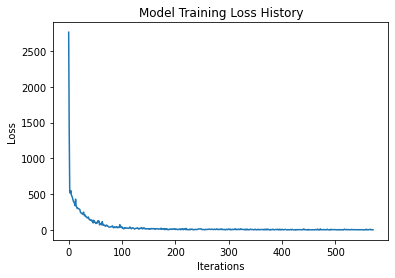

In [47]:
from matplotlib import pyplot as plt
loss_history = [loss['ner'] for loss in train.loss_history]
plt.title("Model Training Loss History")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(loss_history)

In [48]:
accuracy_df = pd.DataFrame(columns = ["score_type", "precision", "recall", "f1"],
                          index = [0,1,2,3,4])
accuracy_df.loc[0] = ["token", accuracy["token_p"], accuracy["token_r"], accuracy["token_f"]]
accuracy_df.loc[1] = ["entity", accuracy["ents_p"], accuracy["ents_r"], accuracy["ents_f"]]
accuracy_df.loc[2] = ["Medicine", accuracy["ents_per_type"]["Medicine"]["p"], accuracy["ents_per_type"]["Medicine"]["r"], accuracy["ents_per_type"]["Medicine"]["f"]]
accuracy_df.loc[3] = ["MedicalCondition", accuracy["ents_per_type"]["MedicalCondition"]["p"], accuracy["ents_per_type"]["MedicalCondition"]["r"], accuracy["ents_per_type"]["MedicalCondition"]["f"]]
accuracy_df.loc[4] = ["Pathogen", accuracy["ents_per_type"]["Pathogen"]["p"], accuracy["ents_per_type"]["Pathogen"]["r"], accuracy["ents_per_type"]["Pathogen"]["f"]]
accuracy_df

,score_type,precision,recall,f1
0,token,1.0,1.0,1.0
1,entity,0.609756,0.471698,0.531915
2,Medicine,0.692308,0.473684,0.5625
3,MedicalCondition,0.583333,0.4375,0.5
4,Pathogen,0.5,1.0,0.666667


In [49]:
type(ruler_model)

__main__.RulerModel

In [50]:
from spacy.pipeline import EntityRuler


def extend_model(MedicalCondition,Medicine,Pathogen):
    train.ner_model = ruler_model.ruler_model    
    @Language.component("my_entity_ruler")
    def ruler_component(doc):
        doc = ruler_model.entity_ruler(doc)
        return doc
    

    
    for entity_type_set in [MedicalCondition,Medicine,Pathogen]:
        for item in entity_type_set:
            train.vocab.strings.add(item)
            
    
    if "my_entity_ruler" in train.pipe_names:
        train.remove_pipe("my_entity_ruler")
        
    train.ner_model.add_pipe("ner")
    train.ner_model.add_pipe("my_entity_ruler", before="ner")
    
    return train


In [51]:
extended_ner_model = extend_model(medicalCondition,medicine,pathogen)

In [52]:
extended_ner_model.fit(training_dataset)

[2023-01-17 15:03:32,191] [INFO] Created vocabulary
[2023-01-17 15:03:32,195] [INFO] Finished initializing nlp object


---- NER model training iteration 1 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


{'ner': 2716.241555452347}
---- NER model training iteration 2 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


{'ner': 1596.8365512825549}
---- NER model training iteration 3 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


{'ner': 549.1050630219676}
---- NER model training iteration 4 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


{'ner': 504.26287340315696}
---- NER model training iteration 5 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.45it/s]


{'ner': 590.23705093842}
---- NER model training iteration 6 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.44it/s]


{'ner': 519.2986689006793}
---- NER model training iteration 7 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


{'ner': 464.4799281970101}
---- NER model training iteration 8 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


{'ner': 449.38726773902545}
---- NER model training iteration 9 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


{'ner': 423.29440404487855}
---- NER model training iteration 10 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


{'ner': 463.0918885774629}
---- NER model training iteration 11 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


{'ner': 384.9299624779772}
---- NER model training iteration 12 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.17it/s]


{'ner': 366.05870945558354}
---- NER model training iteration 13 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


{'ner': 349.1166344385807}
---- NER model training iteration 14 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


{'ner': 380.0675191824173}
---- NER model training iteration 15 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


{'ner': 424.3586632218313}
---- NER model training iteration 16 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


{'ner': 331.2857006725139}
---- NER model training iteration 17 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.23it/s]


{'ner': 309.8018761724603}
---- NER model training iteration 18 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


{'ner': 295.0660953399395}
---- NER model training iteration 19 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


{'ner': 290.8906661235179}
---- NER model training iteration 20 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


{'ner': 272.3015331482024}
---- NER model training iteration 21 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


{'ner': 269.59102841628896}
---- NER model training iteration 22 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


{'ner': 261.59493682016085}
---- NER model training iteration 23 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


{'ner': 248.17573518826458}
---- NER model training iteration 24 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.74it/s]


{'ner': 252.25633517555636}
---- NER model training iteration 25 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


{'ner': 230.3711446332838}
---- NER model training iteration 26 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 242.50261751820375}
---- NER model training iteration 27 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


{'ner': 226.63281485146638}
---- NER model training iteration 28 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.38it/s]


{'ner': 229.71339294318875}
---- NER model training iteration 29 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


{'ner': 200.08709533426742}
---- NER model training iteration 30 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.21it/s]


{'ner': 217.6506718608988}
---- NER model training iteration 31 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.78it/s]


{'ner': 190.82909309458023}
---- NER model training iteration 32 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.92it/s]


{'ner': 187.70356259196046}
---- NER model training iteration 33 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


{'ner': 180.80140963666756}
---- NER model training iteration 34 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.67it/s]


{'ner': 217.19187296674625}
---- NER model training iteration 35 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


{'ner': 183.32319746274916}
---- NER model training iteration 36 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


{'ner': 197.56080071713842}
---- NER model training iteration 37 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.59it/s]


{'ner': 181.43478877454373}
---- NER model training iteration 38 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


{'ner': 152.4690436735879}
---- NER model training iteration 39 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


{'ner': 138.59910239513522}
---- NER model training iteration 40 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


{'ner': 138.51190638842266}
---- NER model training iteration 41 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


{'ner': 122.44567710554094}
---- NER model training iteration 42 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


{'ner': 129.9842749198809}
---- NER model training iteration 43 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


{'ner': 137.25382968824414}
---- NER model training iteration 44 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


{'ner': 119.31325792374443}
---- NER model training iteration 45 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


{'ner': 138.33334935134826}
---- NER model training iteration 46 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


{'ner': 163.04344308745416}
---- NER model training iteration 47 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


{'ner': 119.84741862402069}
---- NER model training iteration 48 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.52it/s]


{'ner': 107.4031224866825}
---- NER model training iteration 49 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


{'ner': 111.5784271775389}
---- NER model training iteration 50 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 102.73225752630326}
---- NER model training iteration 51 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


{'ner': 94.57730838593305}
---- NER model training iteration 52 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


{'ner': 93.45278093853726}
---- NER model training iteration 53 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


{'ner': 85.45178482961934}
---- NER model training iteration 54 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


{'ner': 90.14422440292651}
---- NER model training iteration 55 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


{'ner': 107.08635633020958}
---- NER model training iteration 56 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


{'ner': 97.59731127974757}
---- NER model training iteration 57 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


{'ner': 89.56176656429658}
---- NER model training iteration 58 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


{'ner': 81.04543040200656}
---- NER model training iteration 59 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


{'ner': 138.95892429856542}
---- NER model training iteration 60 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


{'ner': 73.0576065908594}
---- NER model training iteration 61 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.11it/s]


{'ner': 70.58182541599697}
---- NER model training iteration 62 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.47it/s]


{'ner': 62.98848106827259}
---- NER model training iteration 63 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


{'ner': 71.35059345424541}
---- NER model training iteration 64 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.54it/s]


{'ner': 78.45819633692479}
---- NER model training iteration 65 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 84.67076100376083}
---- NER model training iteration 66 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.50it/s]


{'ner': 62.98825515500986}
---- NER model training iteration 67 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.65it/s]


{'ner': 68.79062934669223}
---- NER model training iteration 68 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


{'ner': 62.89782303210419}
---- NER model training iteration 69 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]


{'ner': 52.87289611874878}
---- NER model training iteration 70 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


{'ner': 54.30961077414018}
---- NER model training iteration 71 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


{'ner': 58.84070823639635}
---- NER model training iteration 72 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


{'ner': 53.657323993452465}
---- NER model training iteration 73 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.37it/s]


{'ner': 57.96902635923886}
---- NER model training iteration 74 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.55it/s]


{'ner': 49.851023626850335}
---- NER model training iteration 75 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


{'ner': 66.85808846847891}
---- NER model training iteration 76 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


{'ner': 50.829287244998206}
---- NER model training iteration 77 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


{'ner': 54.23498144242074}
---- NER model training iteration 78 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


{'ner': 55.53374601255707}
---- NER model training iteration 79 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


{'ner': 59.47622592474176}
---- NER model training iteration 80 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


{'ner': 44.84453924321329}
---- NER model training iteration 81 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


{'ner': 34.44414625091679}
---- NER model training iteration 82 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


{'ner': 54.83242371944596}
---- NER model training iteration 83 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


{'ner': 31.828861060410244}
---- NER model training iteration 84 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


{'ner': 33.72613427238228}
---- NER model training iteration 85 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 37.94090771889226}
---- NER model training iteration 86 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


{'ner': 33.61352333351568}
---- NER model training iteration 87 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


{'ner': 32.053014748509405}
---- NER model training iteration 88 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


{'ner': 29.61282412940342}
---- NER model training iteration 89 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


{'ner': 38.05431352462158}
---- NER model training iteration 90 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 26.039824489402047}
---- NER model training iteration 91 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.09it/s]


{'ner': 30.844558858397235}
---- NER model training iteration 92 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


{'ner': 37.476645299471706}
---- NER model training iteration 93 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


{'ner': 38.47661725761571}
---- NER model training iteration 94 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


{'ner': 44.86574974875819}
---- NER model training iteration 95 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


{'ner': 25.960177805788458}
---- NER model training iteration 96 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.96it/s]


{'ner': 35.34302742400311}
---- NER model training iteration 97 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.42it/s]


{'ner': 39.313799275349446}
---- NER model training iteration 98 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


{'ner': 29.100676958066856}
---- NER model training iteration 99 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.07it/s]


{'ner': 26.23499354495123}
---- NER model training iteration 100 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


{'ner': 19.620461996870777}
---- NER model training iteration 101 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


{'ner': 33.28070095711674}
---- NER model training iteration 102 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


{'ner': 25.150512469528824}
---- NER model training iteration 103 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


{'ner': 23.000051237615185}
---- NER model training iteration 104 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.98it/s]


{'ner': 27.229944752532}
---- NER model training iteration 105 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


{'ner': 25.30346414859015}
---- NER model training iteration 106 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


{'ner': 33.16560960317215}
---- NER model training iteration 107 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.42it/s]


{'ner': 24.799662271839264}
---- NER model training iteration 108 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


{'ner': 17.008886256036952}
---- NER model training iteration 109 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 17.436338024232445}
---- NER model training iteration 110 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 30.461940906550435}
---- NER model training iteration 111 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


{'ner': 16.71304337981797}
---- NER model training iteration 112 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.72it/s]


{'ner': 27.312667252007365}
---- NER model training iteration 113 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


{'ner': 30.67823491161111}
---- NER model training iteration 114 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.68it/s]


{'ner': 31.657319542162163}
---- NER model training iteration 115 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


{'ner': 38.36636220730217}
---- NER model training iteration 116 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.55it/s]


{'ner': 29.039106374689002}
---- NER model training iteration 117 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


{'ner': 18.709143922006987}
---- NER model training iteration 118 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


{'ner': 19.684562097096777}
---- NER model training iteration 119 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.66it/s]


{'ner': 15.260521358228303}
---- NER model training iteration 120 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.57it/s]


{'ner': 25.44482103704949}
---- NER model training iteration 121 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


{'ner': 19.377241090634588}
---- NER model training iteration 122 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


{'ner': 11.077448018555172}
---- NER model training iteration 123 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.61it/s]


{'ner': 18.06334031462917}
---- NER model training iteration 124 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


{'ner': 26.87652095289602}
---- NER model training iteration 125 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  8.00it/s]


{'ner': 25.05399201205325}
---- NER model training iteration 126 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


{'ner': 17.97951099371848}
---- NER model training iteration 127 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


{'ner': 18.428604271928542}
---- NER model training iteration 128 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


{'ner': 13.122076365222666}
---- NER model training iteration 129 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


{'ner': 25.750956773421343}
---- NER model training iteration 130 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.87it/s]


{'ner': 29.36708670356551}
---- NER model training iteration 131 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


{'ner': 24.52301953030083}
---- NER model training iteration 132 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


{'ner': 17.12399004479041}
---- NER model training iteration 133 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


{'ner': 16.157057682247945}
---- NER model training iteration 134 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


{'ner': 20.72188918531301}
---- NER model training iteration 135 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.02it/s]


{'ner': 24.838704825887994}
---- NER model training iteration 136 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


{'ner': 21.346293680310946}
---- NER model training iteration 137 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


{'ner': 30.789125486910798}
---- NER model training iteration 138 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


{'ner': 8.015597717177156}
---- NER model training iteration 139 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


{'ner': 17.64770104331208}
---- NER model training iteration 140 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


{'ner': 21.259401720114855}
---- NER model training iteration 141 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


{'ner': 14.761057226781576}
---- NER model training iteration 142 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.01it/s]


{'ner': 10.970421304813065}
---- NER model training iteration 143 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


{'ner': 13.764079640866987}
---- NER model training iteration 144 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


{'ner': 10.530605933728467}
---- NER model training iteration 145 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.27it/s]


{'ner': 8.77895955358015}
---- NER model training iteration 146 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


{'ner': 19.914220606652773}
---- NER model training iteration 147 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


{'ner': 16.062842165285105}
---- NER model training iteration 148 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  8.12it/s]


{'ner': 12.128073690637024}
---- NER model training iteration 149 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


{'ner': 27.932891691811182}
---- NER model training iteration 150 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


{'ner': 24.820089513424303}
---- NER model training iteration 151 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.00it/s]


{'ner': 13.312948204064245}
---- NER model training iteration 152 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


{'ner': 13.565067366853075}
---- NER model training iteration 153 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.58it/s]


{'ner': 21.665688155568912}
---- NER model training iteration 154 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


{'ner': 6.942798217748458}
---- NER model training iteration 155 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


{'ner': 18.45960807915099}
---- NER model training iteration 156 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


{'ner': 12.652408595928273}
---- NER model training iteration 157 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


{'ner': 20.002859334734687}
---- NER model training iteration 158 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


{'ner': 16.115892543564804}
---- NER model training iteration 159 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.19it/s]


{'ner': 20.73480470540286}
---- NER model training iteration 160 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


{'ner': 11.115903734598456}
---- NER model training iteration 161 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


{'ner': 16.091719204249475}
---- NER model training iteration 162 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.75it/s]


{'ner': 14.28601095138144}
---- NER model training iteration 163 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


{'ner': 19.715718139839367}
---- NER model training iteration 164 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 18.18324849193627}
---- NER model training iteration 165 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


{'ner': 15.377571644505094}
---- NER model training iteration 166 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


{'ner': 20.40181577041017}
---- NER model training iteration 167 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


{'ner': 16.446112950873026}
---- NER model training iteration 168 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 17.41732424192594}
---- NER model training iteration 169 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.42it/s]


{'ner': 19.680986074493156}
---- NER model training iteration 170 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


{'ner': 10.641803191823463}
---- NER model training iteration 171 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


{'ner': 15.85631430315526}
---- NER model training iteration 172 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


{'ner': 18.46037562359716}
---- NER model training iteration 173 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.58it/s]


{'ner': 12.923401042937044}
---- NER model training iteration 174 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 24.909691810616952}
---- NER model training iteration 175 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


{'ner': 18.239767851082615}
---- NER model training iteration 176 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 10.710495451258687}
---- NER model training iteration 177 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.53it/s]


{'ner': 13.440591115924532}
---- NER model training iteration 178 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


{'ner': 18.277417563745036}
---- NER model training iteration 179 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


{'ner': 7.465395816997038}
---- NER model training iteration 180 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


{'ner': 11.866488224801266}
---- NER model training iteration 181 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


{'ner': 14.33393919005897}
---- NER model training iteration 182 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.07it/s]


{'ner': 10.404239178518727}
---- NER model training iteration 183 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 11.098529661560244}
---- NER model training iteration 184 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


{'ner': 11.262767456828392}
---- NER model training iteration 185 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.52it/s]


{'ner': 8.903904319971653}
---- NER model training iteration 186 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.14it/s]


{'ner': 18.07615423965072}
---- NER model training iteration 187 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


{'ner': 12.106771532812642}
---- NER model training iteration 188 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.52it/s]


{'ner': 7.8612123993719}
---- NER model training iteration 189 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 8.094366919587383}
---- NER model training iteration 190 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


{'ner': 11.117964891524547}
---- NER model training iteration 191 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


{'ner': 7.862176145585072}
---- NER model training iteration 192 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


{'ner': 13.76026734068343}
---- NER model training iteration 193 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.57it/s]


{'ner': 11.891070285327192}
---- NER model training iteration 194 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


{'ner': 13.43548183322803}
---- NER model training iteration 195 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


{'ner': 6.340257790323307}
---- NER model training iteration 196 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


{'ner': 12.329920114225553}
---- NER model training iteration 197 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


{'ner': 15.948787038626683}
---- NER model training iteration 198 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.65it/s]


{'ner': 2.750390439739802}
---- NER model training iteration 199 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


{'ner': 19.51239509682501}
---- NER model training iteration 200 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


{'ner': 20.983169801122305}
---- NER model training iteration 201 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


{'ner': 16.770641464534048}
---- NER model training iteration 202 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.54it/s]


{'ner': 5.460585157047722}
---- NER model training iteration 203 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  8.33it/s]


{'ner': 20.638818930392933}
---- NER model training iteration 204 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 7.2371411456803685}
---- NER model training iteration 205 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


{'ner': 5.769428520194466}
---- NER model training iteration 206 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


{'ner': 8.784551389605072}
---- NER model training iteration 207 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 7.365179496202801}
---- NER model training iteration 208 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


{'ner': 4.97886211236476}
---- NER model training iteration 209 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.02it/s]


{'ner': 3.4797833865841707}
---- NER model training iteration 210 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.66it/s]


{'ner': 5.665628601226639}
---- NER model training iteration 211 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


{'ner': 16.232005794318923}
---- NER model training iteration 212 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


{'ner': 13.696077060147045}
---- NER model training iteration 213 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


{'ner': 11.397987089908222}
---- NER model training iteration 214 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


{'ner': 2.9494578431730285}
---- NER model training iteration 215 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


{'ner': 17.65927049870443}
---- NER model training iteration 216 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.83it/s]


{'ner': 11.621894660146346}
---- NER model training iteration 217 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


{'ner': 6.34004180601131}
---- NER model training iteration 218 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


{'ner': 7.009019965042805}
---- NER model training iteration 219 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.99it/s]


{'ner': 14.99482640450631}
---- NER model training iteration 220 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


{'ner': 5.644321771771452}
---- NER model training iteration 221 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


{'ner': 7.78496687620577}
---- NER model training iteration 222 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.70it/s]


{'ner': 8.153478274960186}
---- NER model training iteration 223 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


{'ner': 8.68744779889634}
---- NER model training iteration 224 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 11.598409672632563}
---- NER model training iteration 225 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.23it/s]


{'ner': 10.226122325614876}
---- NER model training iteration 226 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


{'ner': 13.006352274898356}
---- NER model training iteration 227 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


{'ner': 11.513263778493577}
---- NER model training iteration 228 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


{'ner': 7.052032978833867}
---- NER model training iteration 229 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


{'ner': 6.39740879235055}
---- NER model training iteration 230 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


{'ner': 17.80700010566412}
---- NER model training iteration 231 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.80it/s]


{'ner': 14.505880904251516}
---- NER model training iteration 232 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


{'ner': 17.425652089891795}
---- NER model training iteration 233 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 7.8760507652332645}
---- NER model training iteration 234 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.28it/s]


{'ner': 13.13879600053611}
---- NER model training iteration 235 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


{'ner': 6.376402908242852}
---- NER model training iteration 236 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.58it/s]


{'ner': 14.163508035266135}
---- NER model training iteration 237 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


{'ner': 1.1093470439978612}
---- NER model training iteration 238 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


{'ner': 3.8764964406254716}
---- NER model training iteration 239 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.79it/s]


{'ner': 2.567098535896051}
---- NER model training iteration 240 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.74it/s]


{'ner': 6.7539974786778565}
---- NER model training iteration 241 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 3.1162580426014403}
---- NER model training iteration 242 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.24it/s]


{'ner': 8.687475389642982}
---- NER model training iteration 243 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 2.5010536247977586}
---- NER model training iteration 244 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.07it/s]


{'ner': 8.223576958721178}
---- NER model training iteration 245 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


{'ner': 7.076898616233772}
---- NER model training iteration 246 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.66it/s]


{'ner': 7.337533937212293}
---- NER model training iteration 247 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.57it/s]


{'ner': 10.959321586607738}
---- NER model training iteration 248 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 11.584628737058802}
---- NER model training iteration 249 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 5.127822330957184}
---- NER model training iteration 250 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


{'ner': 5.85872571903051}
---- NER model training iteration 251 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


{'ner': 6.843000440991806}
---- NER model training iteration 252 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


{'ner': 4.513627113041673}
---- NER model training iteration 253 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


{'ner': 5.9560316967687195}
---- NER model training iteration 254 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


{'ner': 4.550079530974242}
---- NER model training iteration 255 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.30it/s]


{'ner': 9.006590809154963}
---- NER model training iteration 256 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.95it/s]


{'ner': 7.258596081651794}
---- NER model training iteration 257 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


{'ner': 2.8915513628523573}
---- NER model training iteration 258 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.66it/s]


{'ner': 8.408293548411429}
---- NER model training iteration 259 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.13it/s]


{'ner': 15.869001309324833}
---- NER model training iteration 260 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


{'ner': 12.143193441399022}
---- NER model training iteration 261 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.25it/s]


{'ner': 9.325196681232374}
---- NER model training iteration 262 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.23it/s]


{'ner': 8.330916468545086}
---- NER model training iteration 263 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


{'ner': 8.619578994226393}
---- NER model training iteration 264 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


{'ner': 7.059279017864535}
---- NER model training iteration 265 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 13.718177434029595}
---- NER model training iteration 266 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


{'ner': 8.093968375626293}
---- NER model training iteration 267 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


{'ner': 7.790557592487131}
---- NER model training iteration 268 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.39it/s]


{'ner': 3.3067319604977636}
---- NER model training iteration 269 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 4.738302718136427}
---- NER model training iteration 270 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


{'ner': 3.0937740843508488}
---- NER model training iteration 271 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


{'ner': 8.979039293321236}
---- NER model training iteration 272 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.72it/s]


{'ner': 11.938831297086105}
---- NER model training iteration 273 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


{'ner': 2.4201472761141454}
---- NER model training iteration 274 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


{'ner': 9.405981810787601}
---- NER model training iteration 275 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


{'ner': 12.825525972856054}
---- NER model training iteration 276 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


{'ner': 9.182487526036034}
---- NER model training iteration 277 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


{'ner': 9.550788521742826}
---- NER model training iteration 278 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.00it/s]


{'ner': 4.400815561186031}
---- NER model training iteration 279 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


{'ner': 10.22762249706212}
---- NER model training iteration 280 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


{'ner': 4.433657813097891}
---- NER model training iteration 281 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


{'ner': 13.52669006911625}
---- NER model training iteration 282 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


{'ner': 5.6935538764352245}
---- NER model training iteration 283 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


{'ner': 15.153432917391603}
---- NER model training iteration 284 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


{'ner': 18.423745974488853}
---- NER model training iteration 285 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


{'ner': 3.82491507313571}
---- NER model training iteration 286 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.90it/s]


{'ner': 4.65540037788481}
---- NER model training iteration 287 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


{'ner': 11.220472147075075}
---- NER model training iteration 288 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


{'ner': 2.349299441146984}
---- NER model training iteration 289 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


{'ner': 2.189548643615423}
---- NER model training iteration 290 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.87it/s]


{'ner': 3.9603169433542766}
---- NER model training iteration 291 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


{'ner': 12.635528781304018}
---- NER model training iteration 292 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


{'ner': 3.1494770466419575}
---- NER model training iteration 293 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


{'ner': 3.936421530043807}
---- NER model training iteration 294 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


{'ner': 13.2082093954056}
---- NER model training iteration 295 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


{'ner': 9.674476746159314}
---- NER model training iteration 296 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


{'ner': 13.919297034417008}
---- NER model training iteration 297 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


{'ner': 10.23102163087195}
---- NER model training iteration 298 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


{'ner': 2.9652960814276743}
---- NER model training iteration 299 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.49it/s]


{'ner': 7.914202550300827}
---- NER model training iteration 300 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


{'ner': 3.892613753810107}
---- NER model training iteration 301 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.29it/s]


{'ner': 11.10264732231138}
---- NER model training iteration 302 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


{'ner': 0.1960867105149835}
---- NER model training iteration 303 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


{'ner': 6.172628729534987}
---- NER model training iteration 304 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 5.65097788031957}
---- NER model training iteration 305 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


{'ner': 3.3854722981502343}
---- NER model training iteration 306 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


{'ner': 8.833685277963898}
---- NER model training iteration 307 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


{'ner': 0.7605240971666235}
---- NER model training iteration 308 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


{'ner': 8.700010986674654}
---- NER model training iteration 309 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


{'ner': 13.023164829445692}
---- NER model training iteration 310 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


{'ner': 6.478304521691853}
---- NER model training iteration 311 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


{'ner': 1.5222936530979014}
---- NER model training iteration 312 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


{'ner': 3.9129868313204845}
---- NER model training iteration 313 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.61it/s]


{'ner': 4.601944678539538}
---- NER model training iteration 314 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.51it/s]


{'ner': 2.0889858492844917}
---- NER model training iteration 315 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


{'ner': 13.098313404079194}
---- NER model training iteration 316 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.78it/s]


{'ner': 4.3458593632515115}
---- NER model training iteration 317 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


{'ner': 7.7159394827362435}
---- NER model training iteration 318 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.66it/s]


{'ner': 4.017664666606249}
---- NER model training iteration 319 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


{'ner': 4.946226996172649}
---- NER model training iteration 320 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


{'ner': 8.124421495407386}
---- NER model training iteration 321 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.63it/s]


{'ner': 4.552569350030923}
---- NER model training iteration 322 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.83it/s]


{'ner': 7.3245464338497}
---- NER model training iteration 323 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


{'ner': 5.387716733600291}
---- NER model training iteration 324 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


{'ner': 3.872231636824566}
---- NER model training iteration 325 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


{'ner': 4.154157458711052}
---- NER model training iteration 326 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


{'ner': 4.153331791381794}
---- NER model training iteration 327 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


{'ner': 5.626877408306415}
---- NER model training iteration 328 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


{'ner': 3.7088917442505456}
---- NER model training iteration 329 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.65it/s]


{'ner': 4.432653209933038}
---- NER model training iteration 330 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


{'ner': 5.666374277303358}
---- NER model training iteration 331 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


{'ner': 1.6412140253232457}
---- NER model training iteration 332 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.96it/s]


{'ner': 12.853451073350296}
---- NER model training iteration 333 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


{'ner': 4.727182331750992}
---- NER model training iteration 334 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.70it/s]


{'ner': 10.075023419583719}
---- NER model training iteration 335 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.33it/s]


{'ner': 10.502878579159633}
---- NER model training iteration 336 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


{'ner': 7.526846001856637}
---- NER model training iteration 337 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


{'ner': 9.533359887333196}
---- NER model training iteration 338 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 8.97911752443696}
---- NER model training iteration 339 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


{'ner': 8.74409564459905}
---- NER model training iteration 340 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.03it/s]


{'ner': 4.907139631242216}
---- NER model training iteration 341 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


{'ner': 3.4209625491909295}
---- NER model training iteration 342 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


{'ner': 4.171315989793339}
---- NER model training iteration 343 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


{'ner': 10.550970192600381}
---- NER model training iteration 344 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


{'ner': 4.078215894834893}
---- NER model training iteration 345 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


{'ner': 3.849764761342594}
---- NER model training iteration 346 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.24it/s]


{'ner': 3.4139397998438206}
---- NER model training iteration 347 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


{'ner': 0.8773048261977638}
---- NER model training iteration 348 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.92it/s]


{'ner': 2.422211227566942}
---- NER model training iteration 349 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


{'ner': 7.098613206862305}
---- NER model training iteration 350 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


{'ner': 7.820019929377017}
---- NER model training iteration 351 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


{'ner': 2.8986783022421982}
---- NER model training iteration 352 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


{'ner': 5.534970587656525}
---- NER model training iteration 353 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


{'ner': 2.3813778190383266}
---- NER model training iteration 354 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


{'ner': 1.866547735341775}
---- NER model training iteration 355 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


{'ner': 14.314840013078642}
---- NER model training iteration 356 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


{'ner': 2.0471358980878525}
---- NER model training iteration 357 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


{'ner': 2.8030433744988237}
---- NER model training iteration 358 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


{'ner': 0.4486531552453314}
---- NER model training iteration 359 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


{'ner': 0.14495716490412364}
---- NER model training iteration 360 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


{'ner': 4.380794174904052}
---- NER model training iteration 361 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


{'ner': 4.186310478169444}
---- NER model training iteration 362 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


{'ner': 6.899978038156096}
---- NER model training iteration 363 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


{'ner': 3.965727638689901}
---- NER model training iteration 364 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.95it/s]


{'ner': 4.291049750796763}
---- NER model training iteration 365 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 5.060365201806846}
---- NER model training iteration 366 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


{'ner': 0.4352554329068479}
---- NER model training iteration 367 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


{'ner': 11.05429272819253}
---- NER model training iteration 368 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


{'ner': 3.4467813795141833}
---- NER model training iteration 369 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


{'ner': 7.700397204172238}
---- NER model training iteration 370 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


{'ner': 7.587181186736327}
---- NER model training iteration 371 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


{'ner': 5.3846015880015}
---- NER model training iteration 372 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


{'ner': 6.3411921073147335}
---- NER model training iteration 373 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


{'ner': 2.591449248632723}
---- NER model training iteration 374 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


{'ner': 7.016120502483828}
---- NER model training iteration 375 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


{'ner': 6.170649437692465}
---- NER model training iteration 376 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.63it/s]


{'ner': 9.07222566073164}
---- NER model training iteration 377 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


{'ner': 1.4391488013820357}
---- NER model training iteration 378 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


{'ner': 11.0542938266869}
---- NER model training iteration 379 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.64it/s]


{'ner': 5.027005602947513}
---- NER model training iteration 380 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


{'ner': 2.4785114160636033}
---- NER model training iteration 381 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


{'ner': 3.6476117013459546}
---- NER model training iteration 382 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


{'ner': 0.08544268352623914}
---- NER model training iteration 383 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 5.322298613746764}
---- NER model training iteration 384 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.66it/s]


{'ner': 0.00731939285146087}
---- NER model training iteration 385 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


{'ner': 14.342045057018131}
---- NER model training iteration 386 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


{'ner': 3.246395981918389}
---- NER model training iteration 387 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


{'ner': 7.214863532450589}
---- NER model training iteration 388 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


{'ner': 2.362175454963048}
---- NER model training iteration 389 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


{'ner': 1.7186117696163081}
---- NER model training iteration 390 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


{'ner': 2.9893448267263247}
---- NER model training iteration 391 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


{'ner': 3.302398659970721}
---- NER model training iteration 392 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


{'ner': 10.517691035205639}
---- NER model training iteration 393 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


{'ner': 3.4767051247544023}
---- NER model training iteration 394 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.68it/s]


{'ner': 1.537068810556578}
---- NER model training iteration 395 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.08it/s]


{'ner': 1.8699246232548918}
---- NER model training iteration 396 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.06it/s]


{'ner': 0.1753104665127668}
---- NER model training iteration 397 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


{'ner': 7.699243024400185}
---- NER model training iteration 398 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


{'ner': 4.2682491210523645}
---- NER model training iteration 399 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


{'ner': 7.781983437198649}
---- NER model training iteration 400 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


{'ner': 4.541930709734886}
---- NER model training iteration 401 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


{'ner': 5.515398636353338}
---- NER model training iteration 402 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


{'ner': 1.2553702148407118}
---- NER model training iteration 403 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.64it/s]


{'ner': 6.551193394639492}
---- NER model training iteration 404 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


{'ner': 1.5856189818141713}
---- NER model training iteration 405 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


{'ner': 6.971383864202264}
---- NER model training iteration 406 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


{'ner': 7.46693616164829}
---- NER model training iteration 407 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.43it/s]


{'ner': 5.680010285343323}
---- NER model training iteration 408 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


{'ner': 1.638025877343064}
---- NER model training iteration 409 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.38it/s]


{'ner': 6.894145188971886}
---- NER model training iteration 410 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


{'ner': 4.195317674682472}
---- NER model training iteration 411 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


{'ner': 5.269368221806373}
---- NER model training iteration 412 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


{'ner': 1.8645432616106832}
---- NER model training iteration 413 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


{'ner': 2.1749042920009365}
---- NER model training iteration 414 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.97it/s]


{'ner': 5.735522318288577}
---- NER model training iteration 415 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.26it/s]


{'ner': 7.254681914061242}
---- NER model training iteration 416 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.84it/s]


{'ner': 4.203257226647399}
---- NER model training iteration 417 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.28it/s]


{'ner': 9.63222941462911}
---- NER model training iteration 418 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


{'ner': 1.5158956290586227}
---- NER model training iteration 419 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


{'ner': 5.954334290530532}
---- NER model training iteration 420 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


{'ner': 1.998024161228064}
---- NER model training iteration 421 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.56it/s]


{'ner': 9.684319112935126}
---- NER model training iteration 422 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


{'ner': 3.956674805526688}
---- NER model training iteration 423 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.18it/s]


{'ner': 0.054712095818183815}
---- NER model training iteration 424 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


{'ner': 2.2968755001007968}
---- NER model training iteration 425 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


{'ner': 0.002047925008857832}
---- NER model training iteration 426 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


{'ner': 4.406159081905161}
---- NER model training iteration 427 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.14it/s]


{'ner': 2.095844179509884}
---- NER model training iteration 428 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


{'ner': 0.262112408476172}
---- NER model training iteration 429 / 572 ...---


100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


{'ner': 8.641863864754596}
---- NER model training iteration 430 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


{'ner': 2.889452699324979}
---- NER model training iteration 431 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.58it/s]


{'ner': 2.0000719602765873}
---- NER model training iteration 432 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.54it/s]


{'ner': 8.260145290915904}
---- NER model training iteration 433 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


{'ner': 5.211950993793832}
---- NER model training iteration 434 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


{'ner': 2.3267647621633962}
---- NER model training iteration 435 / 572 ...---


100%|██████████| 6/6 [00:02<00:00,  2.98it/s]


{'ner': 2.4227456634738727}
---- NER model training iteration 436 / 572 ...---


100%|██████████| 6/6 [00:02<00:00,  2.84it/s]


{'ner': 4.754517208138283}
---- NER model training iteration 437 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


{'ner': 7.99827488098799}
---- NER model training iteration 438 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


{'ner': 0.22578474137644258}
---- NER model training iteration 439 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


{'ner': 7.441807812759875}
---- NER model training iteration 440 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


{'ner': 2.6287764264820725}
---- NER model training iteration 441 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.24it/s]


{'ner': 3.0138125991412985}
---- NER model training iteration 442 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


{'ner': 9.801145043294827}
---- NER model training iteration 443 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


{'ner': 2.172795679542117}
---- NER model training iteration 444 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.36it/s]


{'ner': 1.4915643927091757}
---- NER model training iteration 445 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 0.0011880982049457043}
---- NER model training iteration 446 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 7.104856270437571}
---- NER model training iteration 447 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.03it/s]


{'ner': 3.684634923280213}
---- NER model training iteration 448 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


{'ner': 0.2907286621426316}
---- NER model training iteration 449 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.20it/s]


{'ner': 1.8160447281657832}
---- NER model training iteration 450 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.21it/s]


{'ner': 3.559246899484923}
---- NER model training iteration 451 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.47it/s]


{'ner': 1.9526993019005752}
---- NER model training iteration 452 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.86it/s]


{'ner': 3.857484243285229}
---- NER model training iteration 453 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.12it/s]


{'ner': 5.9826931464041175}
---- NER model training iteration 454 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


{'ner': 3.3854647975477596}
---- NER model training iteration 455 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.56it/s]


{'ner': 9.424077559722093}
---- NER model training iteration 456 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


{'ner': 0.018010797262885236}
---- NER model training iteration 457 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.48it/s]


{'ner': 5.206916000296913}
---- NER model training iteration 458 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


{'ner': 5.682286895029736}
---- NER model training iteration 459 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


{'ner': 2.734130747084783}
---- NER model training iteration 460 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.12it/s]


{'ner': 5.975505501877581}
---- NER model training iteration 461 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


{'ner': 5.756242948149676}
---- NER model training iteration 462 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 4.136250844415973}
---- NER model training iteration 463 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.47it/s]


{'ner': 0.3539868268478406}
---- NER model training iteration 464 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


{'ner': 1.9021463467161859}
---- NER model training iteration 465 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.65it/s]


{'ner': 2.7592953334653747}
---- NER model training iteration 466 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


{'ner': 0.01842257185755163}
---- NER model training iteration 467 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.27it/s]


{'ner': 5.2456001151713885}
---- NER model training iteration 468 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.94it/s]


{'ner': 2.8878050809012965}
---- NER model training iteration 469 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


{'ner': 3.247240875532204}
---- NER model training iteration 470 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.12it/s]


{'ner': 3.922224828907395}
---- NER model training iteration 471 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.56it/s]


{'ner': 0.056853907004097516}
---- NER model training iteration 472 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.34it/s]


{'ner': 0.012978474476578787}
---- NER model training iteration 473 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.88it/s]


{'ner': 0.05917890752254333}
---- NER model training iteration 474 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


{'ner': 3.1093899642306315}
---- NER model training iteration 475 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.99it/s]


{'ner': 0.022453896469302285}
---- NER model training iteration 476 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.96it/s]


{'ner': 4.410204529666854}
---- NER model training iteration 477 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


{'ner': 7.8233327287821774}
---- NER model training iteration 478 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


{'ner': 1.8223847065825136}
---- NER model training iteration 479 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


{'ner': 1.1903557915452154}
---- NER model training iteration 480 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.40it/s]


{'ner': 0.009692924494257318}
---- NER model training iteration 481 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


{'ner': 5.31430019033529}
---- NER model training iteration 482 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.89it/s]


{'ner': 4.65858552922435}
---- NER model training iteration 483 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.36it/s]


{'ner': 5.690351000943638}
---- NER model training iteration 484 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.79it/s]


{'ner': 7.28085772642755}
---- NER model training iteration 485 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.51it/s]


{'ner': 0.05249162414050534}
---- NER model training iteration 486 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.15it/s]


{'ner': 5.991056950995112}
---- NER model training iteration 487 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.18it/s]


{'ner': 5.285818445631817}
---- NER model training iteration 488 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.27it/s]


{'ner': 1.1887715457072265}
---- NER model training iteration 489 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.16it/s]


{'ner': 1.1287977833974128}
---- NER model training iteration 490 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 1.9903245692867182}
---- NER model training iteration 491 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.22it/s]


{'ner': 5.338822949191077}
---- NER model training iteration 492 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.17it/s]


{'ner': 3.9962085333772293}
---- NER model training iteration 493 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 3.9653502643397993}
---- NER model training iteration 494 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.57it/s]


{'ner': 0.05248340284998908}
---- NER model training iteration 495 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


{'ner': 9.044452029330609}
---- NER model training iteration 496 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 1.336629151308389}
---- NER model training iteration 497 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


{'ner': 6.547029839620104}
---- NER model training iteration 498 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.34it/s]


{'ner': 5.728103638340234}
---- NER model training iteration 499 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.10it/s]


{'ner': 3.930778027555199}
---- NER model training iteration 500 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


{'ner': 6.23550383322928}
---- NER model training iteration 501 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.63it/s]


{'ner': 5.520195051342204}
---- NER model training iteration 502 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.74it/s]


{'ner': 0.0007157739975979793}
---- NER model training iteration 503 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


{'ner': 7.943969300208041}
---- NER model training iteration 504 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.30it/s]


{'ner': 1.578642032187041}
---- NER model training iteration 505 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


{'ner': 8.775015609404402}
---- NER model training iteration 506 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


{'ner': 4.846542993779419}
---- NER model training iteration 507 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


{'ner': 4.167978005085144}
---- NER model training iteration 508 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.76it/s]


{'ner': 0.26764237237523403}
---- NER model training iteration 509 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


{'ner': 2.0300978990802423}
---- NER model training iteration 510 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


{'ner': 2.909592089844951}
---- NER model training iteration 511 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


{'ner': 0.1068777812246298}
---- NER model training iteration 512 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 0.9681119943577885}
---- NER model training iteration 513 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


{'ner': 1.2907000408412719}
---- NER model training iteration 514 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


{'ner': 0.0005454122865679892}
---- NER model training iteration 515 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.86it/s]


{'ner': 3.6933864098909894}
---- NER model training iteration 516 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


{'ner': 5.267158499293952e-07}
---- NER model training iteration 517 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.61it/s]


{'ner': 1.1662627620871604}
---- NER model training iteration 518 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.46it/s]


{'ner': 4.980690924808988}
---- NER model training iteration 519 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.71it/s]


{'ner': 0.00047370143849513396}
---- NER model training iteration 520 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.80it/s]


{'ner': 2.818739255935952}
---- NER model training iteration 521 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


{'ner': 7.555829038395213}
---- NER model training iteration 522 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.46it/s]


{'ner': 1.18666021207214e-05}
---- NER model training iteration 523 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


{'ner': 10.544508808999629}
---- NER model training iteration 524 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.78it/s]


{'ner': 5.565178007173393}
---- NER model training iteration 525 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.55it/s]


{'ner': 2.2026148662868232}
---- NER model training iteration 526 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


{'ner': 0.06290975350757504}
---- NER model training iteration 527 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.80it/s]


{'ner': 2.640863182446595}
---- NER model training iteration 528 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.81it/s]


{'ner': 0.05473002511342773}
---- NER model training iteration 529 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


{'ner': 4.801380596740569e-05}
---- NER model training iteration 530 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.84it/s]


{'ner': 5.979202754426693}
---- NER model training iteration 531 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


{'ner': 7.959312857218917}
---- NER model training iteration 532 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.06it/s]


{'ner': 1.583789186781638e-05}
---- NER model training iteration 533 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.14it/s]


{'ner': 1.9766466670465221}
---- NER model training iteration 534 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


{'ner': 0.02071948561580914}
---- NER model training iteration 535 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.87it/s]


{'ner': 1.972739875622948}
---- NER model training iteration 536 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.45it/s]


{'ner': 0.0012250120651359215}
---- NER model training iteration 537 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.79it/s]


{'ner': 1.494318597683237}
---- NER model training iteration 538 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.82it/s]


{'ner': 2.008794749351073}
---- NER model training iteration 539 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.41it/s]


{'ner': 3.9629341331493917}
---- NER model training iteration 540 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.77it/s]


{'ner': 4.0075721698828275}
---- NER model training iteration 541 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


{'ner': 9.912352672797756}
---- NER model training iteration 542 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.91it/s]


{'ner': 0.00046596554815006623}
---- NER model training iteration 543 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


{'ner': 1.625171037271718}
---- NER model training iteration 544 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.98it/s]


{'ner': 1.056124740906861}
---- NER model training iteration 545 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.92it/s]


{'ner': 0.8512148684462107}
---- NER model training iteration 546 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


{'ner': 4.2088989223318505}
---- NER model training iteration 547 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.62it/s]


{'ner': 3.0242645639395455e-05}
---- NER model training iteration 548 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.32it/s]


{'ner': 5.954535393417792}
---- NER model training iteration 549 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.04it/s]


{'ner': 3.653777685568667}
---- NER model training iteration 550 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  6.00it/s]


{'ner': 4.550507126091678}
---- NER model training iteration 551 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


{'ner': 1.8811314490392863}
---- NER model training iteration 552 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  7.10it/s]


{'ner': 11.10164907963239}
---- NER model training iteration 553 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.53it/s]


{'ner': 4.200423030700558}
---- NER model training iteration 554 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


{'ner': 5.204183396948054}
---- NER model training iteration 555 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


{'ner': 0.0526234603474736}
---- NER model training iteration 556 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


{'ner': 2.3713525655750076}
---- NER model training iteration 557 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


{'ner': 12.356962927106693}
---- NER model training iteration 558 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


{'ner': 1.8990317109394914}
---- NER model training iteration 559 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.50it/s]


{'ner': 0.013349793471563008}
---- NER model training iteration 560 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.16it/s]


{'ner': 6.90416546088611}
---- NER model training iteration 561 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.76it/s]


{'ner': 0.14481417823162082}
---- NER model training iteration 562 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


{'ner': 0.021584708084469512}
---- NER model training iteration 563 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


{'ner': 1.9278630875837914}
---- NER model training iteration 564 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.75it/s]


{'ner': 1.9534272734956266}
---- NER model training iteration 565 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


{'ner': 0.20190740880008776}
---- NER model training iteration 566 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.81it/s]


{'ner': 0.00013261565888432141}
---- NER model training iteration 567 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  4.83it/s]


{'ner': 0.0027712161019150935}
---- NER model training iteration 568 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


{'ner': 1.273587684847365}
---- NER model training iteration 569 / 572 ...---


100%|██████████| 6/6 [00:00<00:00,  6.44it/s]


{'ner': 5.946917899555497}
---- NER model training iteration 570 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.85it/s]


{'ner': 4.434158208440985}
---- NER model training iteration 571 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


{'ner': 3.930890928395915}
---- NER model training iteration 572 / 572 ...---


100%|██████████| 6/6 [00:01<00:00,  5.83it/s]

{'ner': 2.246687091855298}


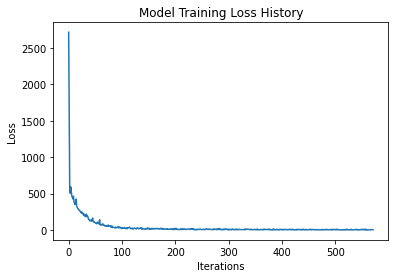

In [53]:
from matplotlib import pyplot as plt
loss_history = [loss['ner'] for loss in extended_ner_model.loss_history]
plt.title("Model Training Loss History")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(loss_history)

In [54]:
extended_accuracy = extended_ner_model.accuracy_score(validation_dataset)
extended_accuracy

{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'sents_p': None,
 'sents_r': None,
 'sents_f': None,
 'tag_acc': None,
 'pos_acc': None,
 'morph_acc': None,
 'morph_micro_p': None,
 'morph_micro_r': None,
 'morph_micro_f': None,
 'morph_per_feat': None,
 'dep_uas': None,
 'dep_las': None,
 'dep_las_per_type': None,
 'ents_p': 0.8412698412698413,
 'ents_r': 1.0,
 'ents_f': 0.9137931034482758,
 'ents_per_type': {'Medicine': {'p': 0.8260869565217391,
   'r': 1.0,
   'f': 0.9047619047619047},
  'MedicalCondition': {'p': 0.8648648648648649,
   'r': 1.0,
   'f': 0.927536231884058},
  'Pathogen': {'p': 0.6666666666666666, 'r': 1.0, 'f': 0.8}},
 'cats_score': 0.0,
 'cats_score_desc': 'macro F',
 'cats_micro_p': 0.0,
 'cats_micro_r': 0.0,
 'cats_micro_f': 0.0,
 'cats_macro_p': 0.0,
 'cats_macro_r': 0.0,
 'cats_macro_f': 0.0,
 'cats_macro_auc': 0.0,
 'cats_f_per_type': {},
 'cats_auc_per_type': {}}

In [55]:
accuracy_df

,score_type,precision,recall,f1
0,token,1.0,1.0,1.0
1,entity,0.609756,0.471698,0.531915
2,Medicine,0.692308,0.473684,0.5625
3,MedicalCondition,0.583333,0.4375,0.5
4,Pathogen,0.5,1.0,0.666667


In [56]:
extended_accuracy_df = pd.DataFrame(columns = ["score_type", "precision", "recall", "f1"],
                          index = [0,1,2,3,4])
extended_accuracy_df.loc[0] = ["token", extended_accuracy["token_p"], extended_accuracy["token_r"], extended_accuracy["token_f"]]
extended_accuracy_df.loc[1] = ["entity", extended_accuracy["ents_p"], extended_accuracy["ents_r"], extended_accuracy["ents_f"]]
extended_accuracy_df.loc[2] = ["Medicine", extended_accuracy["ents_per_type"]["Medicine"]["p"], extended_accuracy["ents_per_type"]["Medicine"]["r"], extended_accuracy["ents_per_type"]["Medicine"]["f"]]
extended_accuracy_df.loc[3] = ["MedicalCondition", extended_accuracy["ents_per_type"]["MedicalCondition"]["p"], extended_accuracy["ents_per_type"]["MedicalCondition"]["r"], extended_accuracy["ents_per_type"]["MedicalCondition"]["f"]]
extended_accuracy_df.loc[4] = ["Pathogen", extended_accuracy["ents_per_type"]["Pathogen"]["p"], extended_accuracy["ents_per_type"]["Pathogen"]["r"], extended_accuracy["ents_per_type"]["Pathogen"]["f"]]
extended_accuracy_df

,score_type,precision,recall,f1
0,token,1.0,1.0,1.0
1,entity,0.84127,1.0,0.913793
2,Medicine,0.826087,1.0,0.904762
3,MedicalCondition,0.864865,1.0,0.927536
4,Pathogen,0.666667,1.0,0.8


In [57]:
test_txt = """Diabetes is a chronic medical condition characterized by high blood sugar levels. It is caused by a lack of insulin production or the body's inability to properly use insulin. 
The most common form of diabetes is type 2 diabetes, which is typically caused by lifestyle factors such as obesity and lack of physical activity. 
Type 1 diabetes is an autoimmune disorder that results in the destruction of the insulin-producing cells in the pancreas.\n
To manage diabetes, individuals may be prescribed medications such as metformin, which helps to lower blood sugar levels by increasing insulin sensitivity. 
Other medications, such as sulfonylureas, stimulate the pancreas to produce more insulin. In some cases, insulin injections may be necessary to control blood sugar levels.\n
In addition to medications, individuals with diabetes should also focus on maintaining a healthy diet and exercise regimen. This includes consuming a diet low in sugar and refined carbohydrates, and engaging in regular physical activity.\n
Furthermore, individuals with diabetes are at a higher risk of developing complications such as heart disease, kidney disease, and neuropathy. This is because high blood sugar levels can damage the blood vessels and nerves over time. To prevent these complications, it is important for individuals with diabetes to keep their blood sugar levels under control and to receive regular check-ups with their healthcare provider.\n
Another medical condition is influenza, which is a highly contagious respiratory illness caused by the influenza virus. Symptoms include fever, cough, sore throat, and body aches. In severe cases, influenza can lead to hospitalization and even death. To prevent the spread of influenza, it is important to get a flu shot annually and to practice good hygiene, such as washing your hands frequently and covering your mouth when you cough or sneeze.\n
Antiviral medications such as oseltamivir and zanamivir can be prescribed to treat influenza. These medications work by inhibiting the replication of the influenza virus, which can help to reduce the severity and duration of symptoms.\n
In addition to influenza, other viral infections such as the coronavirus can also cause respiratory illness. The coronavirus is a highly contagious respiratory illness caused by the SARS-CoV-2 virus. Symptoms include fever, cough, and shortness of breath. To prevent the spread of coronavirus, it is important to practice social distancing, wear a face mask, and to get a vaccine once it becomes available.\n
In conclusion, medical conditions such as diabetes and influenza, as well as pathogen-caused illnesses like coronavirus, can greatly impact an individual's health and well-being. It is important to understand the causes and risk factors associated with these conditions and to take the necessary steps to manage and prevent them through proper treatment and preventative measures. It is vital to stay informed and to consult with a healthcare professional to ensure the best possible outcome.
"""


In [58]:
entities = dataset.find_entity_types(test_txt)
print(entities)

[(0, 8, 'Medicine'), (347, 366, 'MedicalCondition'), (1431, 1439, 'MedicalCondition'), (1471, 1480, 'MedicalCondition'), (1545, 1560, 'Pathogen'), (1586, 1591, 'MedicalCondition'), (1593, 1604, 'MedicalCondition'), (1639, 1648, 'MedicalCondition'), (1718, 1727, 'MedicalCondition'), (1858, 1863, 'Medicine'), (1873, 1878, 'MedicalCondition'), (1921, 1932, 'Medicine'), (1937, 1946, 'Medicine'), (1974, 1983, 'MedicalCondition'), (2045, 2060, 'Pathogen'), (2142, 2151, 'MedicalCondition'), (2188, 2199, 'Pathogen'), (2240, 2251, 'Pathogen'), (2309, 2313, 'MedicalCondition'), (2320, 2325, 'Pathogen'), (2351, 2356, 'MedicalCondition'), (2408, 2419, 'Pathogen'), (2449, 2466, 'MedicalCondition'), (2499, 2506, 'Medicine'), (2590, 2599, 'MedicalCondition'), (2643, 2654, 'Pathogen')]


In [59]:
test_doc = extended_ner_model.ner_model(test_txt)
type(test_doc)

spacy.tokens.doc.Doc

In [60]:
test_doc

Diabetes is a chronic medical condition characterized by high blood sugar levels. It is caused by a lack of insulin production or the body's inability to properly use insulin. 
The most common form of diabetes is type 2 diabetes, which is typically caused by lifestyle factors such as obesity and lack of physical activity. 
Type 1 diabetes is an autoimmune disorder that results in the destruction of the insulin-producing cells in the pancreas.

To manage diabetes, individuals may be prescribed medications such as metformin, which helps to lower blood sugar levels by increasing insulin sensitivity. 
Other medications, such as sulfonylureas, stimulate the pancreas to produce more insulin. In some cases, insulin injections may be necessary to control blood sugar levels.

In addition to medications, individuals with diabetes should also focus on maintaining a healthy diet and exercise regimen. This includes consuming a diet low in sugar and refined carbohydrates, and engaging in regular phy

In [61]:
from spacy import displacy

In [62]:
test_doc.ents


(Diabetes,
 autoimmune disorder,
 provider,
 influenza,
 influenza virus,
 cough,
 sore throat,
 influenza,
 influenza,
 mouth,
 cough,
 oseltamivir,
 zanamivir,
 influenza,
 influenza virus,
 influenza,
 coronavirus,
 coronavirus,
 SARS,
 virus,
 cough,
 coronavirus,
 social distancing,
 vaccine,
 influenza,
 coronavirus)

In [63]:
def display_txt(doc):
    colors = {"MedicalCondition": "orange",
             "Medicine": "lightblue",
             "Pathogen": "lightgreen",
             }
    options = {"ents": ["MedicalCondition",
                       "Medicine",
                       "Pathogen",
                       ],
              "colors": colors}
    displacy.render(doc, style="ent", options=options, jupyter=True)
    
display_txt(test_doc)
